In [1]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import csv
import sys
import os
import re
%matplotlib inline

<a id='0'></a>
# Outline

## [PART 0: Data for K-means](#0.5) 
Use the dictionary create by function "heatmap_bulk_processing()" in MRT_cleaning_visualizing.ipynb as raw_data

## [Part 1: K-means analysis](#1) 
- 1.1 Run K-means analysis
- 1.2Reshape data back to table

## [Part 2: Visualization Grouped by Cluster Result](#2)
- 2.1 Heatmap
- 2.2 Line graph

## [Part 3 Module the Process](#3)
Combine the processes above into K_means_package which consists of:
- k_means_generator   : create K-means results
- cluster_station_dict: save result into a csv file
- line_graph_painter
- heat_map_painter

## [Part 4 Combine Entrance and Exit Result Using K_means_package](#4)


<a id='0.5'></a>
### [PART 0: Data for K-means](#0) 

Use the dictionary create by function "heatmap_bulk_processing()" in MRT_cleaning_visualizing.ipynb as raw_data

In [2]:
def station_eng_name():
    file_ID = 'station_name.csv'
    with open(file_ID, 'r', encoding="utf-8") as fid:
        stationlist = csv.reader(fid)
        id_dict = {rows[0]:rows[3] for rows in stationlist}
    return id_dict

def get_df_max(df):
    max_value = 0
    for item in df.columns:
        if df[item].max() > max_value:
            max_value = df[item].max()
    return max_value

def station_table_to_list(station_sum_up):
    #1 normalizing data
    normalize = round(station_sum_up/get_df_max(station_sum_up),2)
    #2 transform to a list of lists
    middle_list = normalize.values.tolist()
    #3 transform to a single list
    result_list = [item for sub in middle_list for item in sub]
    
    return result_list

def drop_empty_df(df_from_bulk_processing):
    drop_empty_dict = {}
    for k,v in df_from_bulk_processing.items():
        if v[0].empty:
            pass
        else:
            drop_empty_dict[k] = v
    return drop_empty_dict

def station_list(bulk_processing):
    result_list = {}
    for k,v in bulk_processing.items():
        result_list["{} IN".format(k)] = station_table_to_list(bulk_processing[k][0])
        result_list["{} OUT".format(k)] = station_table_to_list(bulk_processing[k][1])

    return result_list

def oneD_list(result_list,file_name):
    oneD = pd.DataFrame(result_list).T
    oneD.to_csv('{}.csv'.format(file_name),encoding='utf-8')
    

#all_line = heatmap_bulk_processing(df,'[A-Z]+[0-9]+') <-from "MRT_cleaning_visualizing.ipynb"
#all_line = drop_empty_df(all_line)
#all_list = station_list(all_line)
#oneD_list(all_list,'forKmeans')

<a id='1'></a>
### [Part 1: K-means analysis](#0) 
- 1.1 Run K-means analysis
- 1.2 Reshape data back to table

In [3]:
df = pd.read_csv('forKmeans.csv',index_col=0)
df.head(10)

0    1    2     3     4     5     6     7     8     9  ...   \
BL01 IN   0.00  0.0  0.0  0.12  0.47  1.00  0.47  0.24  0.18  0.18  ...    
BL01 OUT  0.10  0.0  0.0  0.10  0.90  0.90  0.20  0.20  0.20  0.20  ...    
BL02 IN   0.00  0.0  0.0  0.08  0.54  1.00  0.62  0.38  0.29  0.25  ...    
BL02 OUT  0.06  0.0  0.0  0.18  0.53  0.47  0.24  0.18  0.18  0.24  ...    
BL03 IN   0.00  0.0  0.0  0.12  0.44  0.94  0.50  0.31  0.25  0.25  ...    
BL03 OUT  0.10  0.0  0.0  0.10  0.30  0.40  0.20  0.20  0.20  0.20  ...    
BL04 IN   0.00  0.0  0.0  0.11  0.45  0.96  0.45  0.25  0.21  0.21  ...    
BL04 OUT  0.06  0.0  0.0  0.03  0.14  0.20  0.14  0.11  0.14  0.17  ...    
BL05 IN   0.02  0.0  0.0  0.12  0.42  0.96  0.46  0.27  0.25  0.23  ...    
BL05 OUT  0.07  0.0  0.0  0.10  0.37  0.43  0.37  0.27  0.20  0.20  ...    

           137   138   139   140   141   142   143   144   145   146  
BL01 IN   0.24  0.18  0.24  0.24  0.24  0.18  0.12  0.12  0.06  0.00  
BL01 OUT  0.40  0.30  0.40  0.50  0.60  0.50  0.50  0.60  0.50  0.30  
BL02 IN   0.29  0.25  0.25  0.29  0.29  0.21  0.21  0.21  0.12  0.04  
BL02 OUT  0.29  0.41  0.41  0.59  0.53  0.53  0.47  0.47  0.41  0.18  
BL03 IN   0.25  0.19  0.19  0.19  0.19  0.12  0.12  0.12  0.06  0.06  
BL03 OUT  0.30  0.30  0.40  0.50  0.50  0.40  0.40  0.50  0.40  0.20  
BL04 IN   0.23  0.19  0.15  0.17  0.15  0.11  0.09  0.08  0.06  0.02  
BL04 OUT  0.23  0.26  0.34  0.40  0.46  0.37  0.40  0.46  0.43  0.20  
BL05 IN   0.19  0.15  0.15  0.17  0.15  0.10  0.10  0.08  0.06  0.02  
BL05 OUT  0.27  0.27  0.30  0.40  0.40  0.33  0.33  0.37  0.33  0.13  

[10 rows x 147 columns]

In [4]:
#1.1 create K-means clusters
def k_means_df(df,num_clusters):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df)
    df['cluster'] = kmeans.labels_
    return df

#1.2 reshape data from list back to a table with 7 rows(weekday) and 21* columns, 
#    and group them based on their cluster.

# *There are 21 hours a day in MRT hourly data, without 2~4 a.m.
def k_means_list(km_df):
    group_dict = {}
    for station in km_df.index:
        #get the k-mens grouping
        station_group = km_df.loc[station][-1]

        new_list =[]
        old_list = km_df.loc[station].tolist()

        week_list = []
        for number in old_list:            
            if len(week_list) < 21:
                week_list.append(number)
            else:
                new_list.append(week_list)
                week_list = []
                week_list.append(number)

        result_df = pd.DataFrame(new_list,columns=[0,1,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23],
                                 index=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
        station_dict = {}
        station_dict[station] = result_df
        #https://docs.quantifiedcode.com/python-anti-patterns/correctness/not_using_setdefault_to_initialize_a_dictionary.html
        group_dict.setdefault(station_group, []).append(station_dict)
        
    return group_dict


In [5]:
# "df" contains both entrance and exit data
# "df_out" contains exit data only and will be used as an example for further visualization
k = 4
df_out = df.filter(regex='OUT$', axis=0)
df_out_km = k_means_df(df_out, k)
df_out_km.head()

0    1    2     3     4     5     6     7     8     9   ...     \
BL01 OUT  0.10  0.0  0.0  0.10  0.90  0.90  0.20  0.20  0.20  0.20   ...      
BL02 OUT  0.06  0.0  0.0  0.18  0.53  0.47  0.24  0.18  0.18  0.24   ...      
BL03 OUT  0.10  0.0  0.0  0.10  0.30  0.40  0.20  0.20  0.20  0.20   ...      
BL04 OUT  0.06  0.0  0.0  0.03  0.14  0.20  0.14  0.11  0.14  0.17   ...      
BL05 OUT  0.07  0.0  0.0  0.10  0.37  0.43  0.37  0.27  0.20  0.20   ...      

           138   139   140   141   142   143   144   145   146  cluster  
BL01 OUT  0.30  0.40  0.50  0.60  0.50  0.50  0.60  0.50  0.30        0  
BL02 OUT  0.41  0.41  0.59  0.53  0.53  0.47  0.47  0.41  0.18        0  
BL03 OUT  0.30  0.40  0.50  0.50  0.40  0.40  0.50  0.40  0.20        1  
BL04 OUT  0.26  0.34  0.40  0.46  0.37  0.40  0.46  0.43  0.20        1  
BL05 OUT  0.27  0.30  0.40  0.40  0.33  0.33  0.37  0.33  0.13        1  

[5 rows x 148 columns]

In [6]:
df_km_dict = k_means_list(df_out_km)
print("In terms of leaving the station")
for k, v in df_km_dict.items():
    print("There are {} stations beloings to cluster {}.".format(len(df_km_dict[k]),k))
    
print("\n2 data table in cluster 0:")
df_km_dict[0][:2]

In terms of leaving the station
There are 29 stations beloings to cluster 0.0.
There are 32 stations beloings to cluster 1.0.
There are 15 stations beloings to cluster 3.0.
There are 32 stations beloings to cluster 2.0.

2 data table in cluster 0:


[{'BL01 OUT':       0    1    5    6    7    8    9    10   11   12 ...    14   15   16  \
  Mon  0.1  0.0  0.0  0.1  0.9  0.9  0.2  0.2  0.2  0.2 ...   0.2  0.3  0.3   
  Tue  0.1  0.0  0.0  0.1  0.9  0.9  0.3  0.2  0.2  0.2 ...   0.2  0.3  0.4   
  Wed  0.1  0.0  0.0  0.1  0.7  0.7  0.2  0.1  0.2  0.2 ...   0.2  0.3  0.3   
  Thu  0.1  0.0  0.0  0.1  0.9  0.9  0.3  0.2  0.2  0.2 ...   0.2  0.3  0.3   
  Fri  0.2  0.0  0.0  0.1  0.9  1.0  0.2  0.2  0.2  0.2 ...   0.2  0.3  0.4   
  Sat  0.2  0.0  0.0  0.1  0.2  0.2  0.2  0.2  0.2  0.3 ...   0.3  0.3  0.4   
  Sun  0.1  0.0  0.0  0.1  0.1  0.1  0.2  0.2  0.2  0.2 ...   0.4  0.3  0.4   
  
        17   18   19   20   21   22   23  
  Mon  0.5  0.9  0.8  0.6  0.5  0.6  0.3  
  Tue  0.7  0.8  0.7  0.5  0.5  0.5  0.2  
  Wed  0.5  0.8  0.7  0.6  0.5  0.6  0.3  
  Thu  0.5  0.8  0.8  0.6  0.6  0.7  0.3  
  Fri  0.5  0.8  0.8  0.6  0.6  0.8  0.4  
  Sat  0.5  0.5  0.5  0.5  0.5  0.7  0.4  
  Sun  0.5  0.6  0.5  0.5  0.6  0.5  0.3  
  
  [7 r

<a id='2'></a>
### [Part 2: Visualization Grouped by Cluster Result](#0)
- 2.1 Heatmap
- 2.2 Line graph

In [7]:
#2.1 multiple heatmap generator
def heat_map2(group_dict,col_num,color,file_name,saved_folder,example=None):
    english_name = station_eng_name()
    for cluster in group_dict:
        sys.stdout.write('\rprocessing heatmap cluster: {},cluster length: {}\n'.format(int(cluster),len(group_dict[cluster])))

        if len(group_dict[cluster]) % col_num == 0:
               heigh = int(len(group_dict[cluster])/col_num)
        else:
               heigh = int(len(group_dict[cluster])/col_num) + 1
                                
        fig, ax = plt.subplots(heigh,col_num,figsize = (12*col_num,6*heigh))   
        fig.subplots_adjust(hspace = .3)
               
        cbar_ax = fig.add_axes([.91, .3, .01, .2])
        
        for i in range(0,len(group_dict[cluster])):
            #col_num yx, or high xy depends on how you want maps to be ordered, right to left and next row, 
            # or top to bottom and next column
            location_y = int(i%col_num)
            location_x = int(i/col_num)
            sys.stdout.write('\rprocessing {} ax[{}, {}]'.format(i,location_x,location_y))

            for k,v in group_dict[cluster][i].items():
                for key in english_name.keys(): 
                    if key == k.split()[0]:
                        station_name = english_name[key]                 
                
                # ax index with reference to:
                # https://stackoverflow.com/questions/49809027/matplotlib-subplots-too-many-indices-for-array
                try:
                    heatmap = sns.heatmap(group_dict[cluster][i][k]*100,center=None,
                                          ax = ax[location_x,location_y],
                                          cbar=i == 0,
                                          cmap=color,
                                          vmin= 0,
                                          vmax= 100,
                                          annot=True,
                                          cbar_ax=None if i else cbar_ax,
                                          fmt='g')       
                    ax[location_x,location_y].set_title('{}_{}_cluster: {}'.format(k,station_name,cluster),
                                                        y=1.1)
                    ax[location_x,location_y].xaxis.tick_top()
                    ax[location_x,location_y].set_xlabel('Time of Day')
                    
                    
                except IndexError:
                    heatmap = sns.heatmap(group_dict[cluster][i][k]*100,center=None,
                                          ax = ax[i],
                                          cbar=i == 0,
                                          cmap=color,
                                          vmin= 0,
                                          vmax= 100,
                                          annot=True,
                                          cbar_ax=None if i else cbar_ax,
                                          fmt='g')       
                    ax[i].set_title('{}_{}_cluster: {}'.format(k,station_name,cluster),
                                    y=1.1)
                    ax[i].xaxis.tick_top()
                    ax[i].set_xlabel('Time of Day')
               
        plt.savefig('{}/{}_{}_{}.png'.format(saved_folder,file_name,int(cluster),len(group_dict)-1),
                    bbox_inches='tight')
        if example != None:
            break
        


processing cluster: 0,cluster length: 29
processing 28 ax[7, 0]

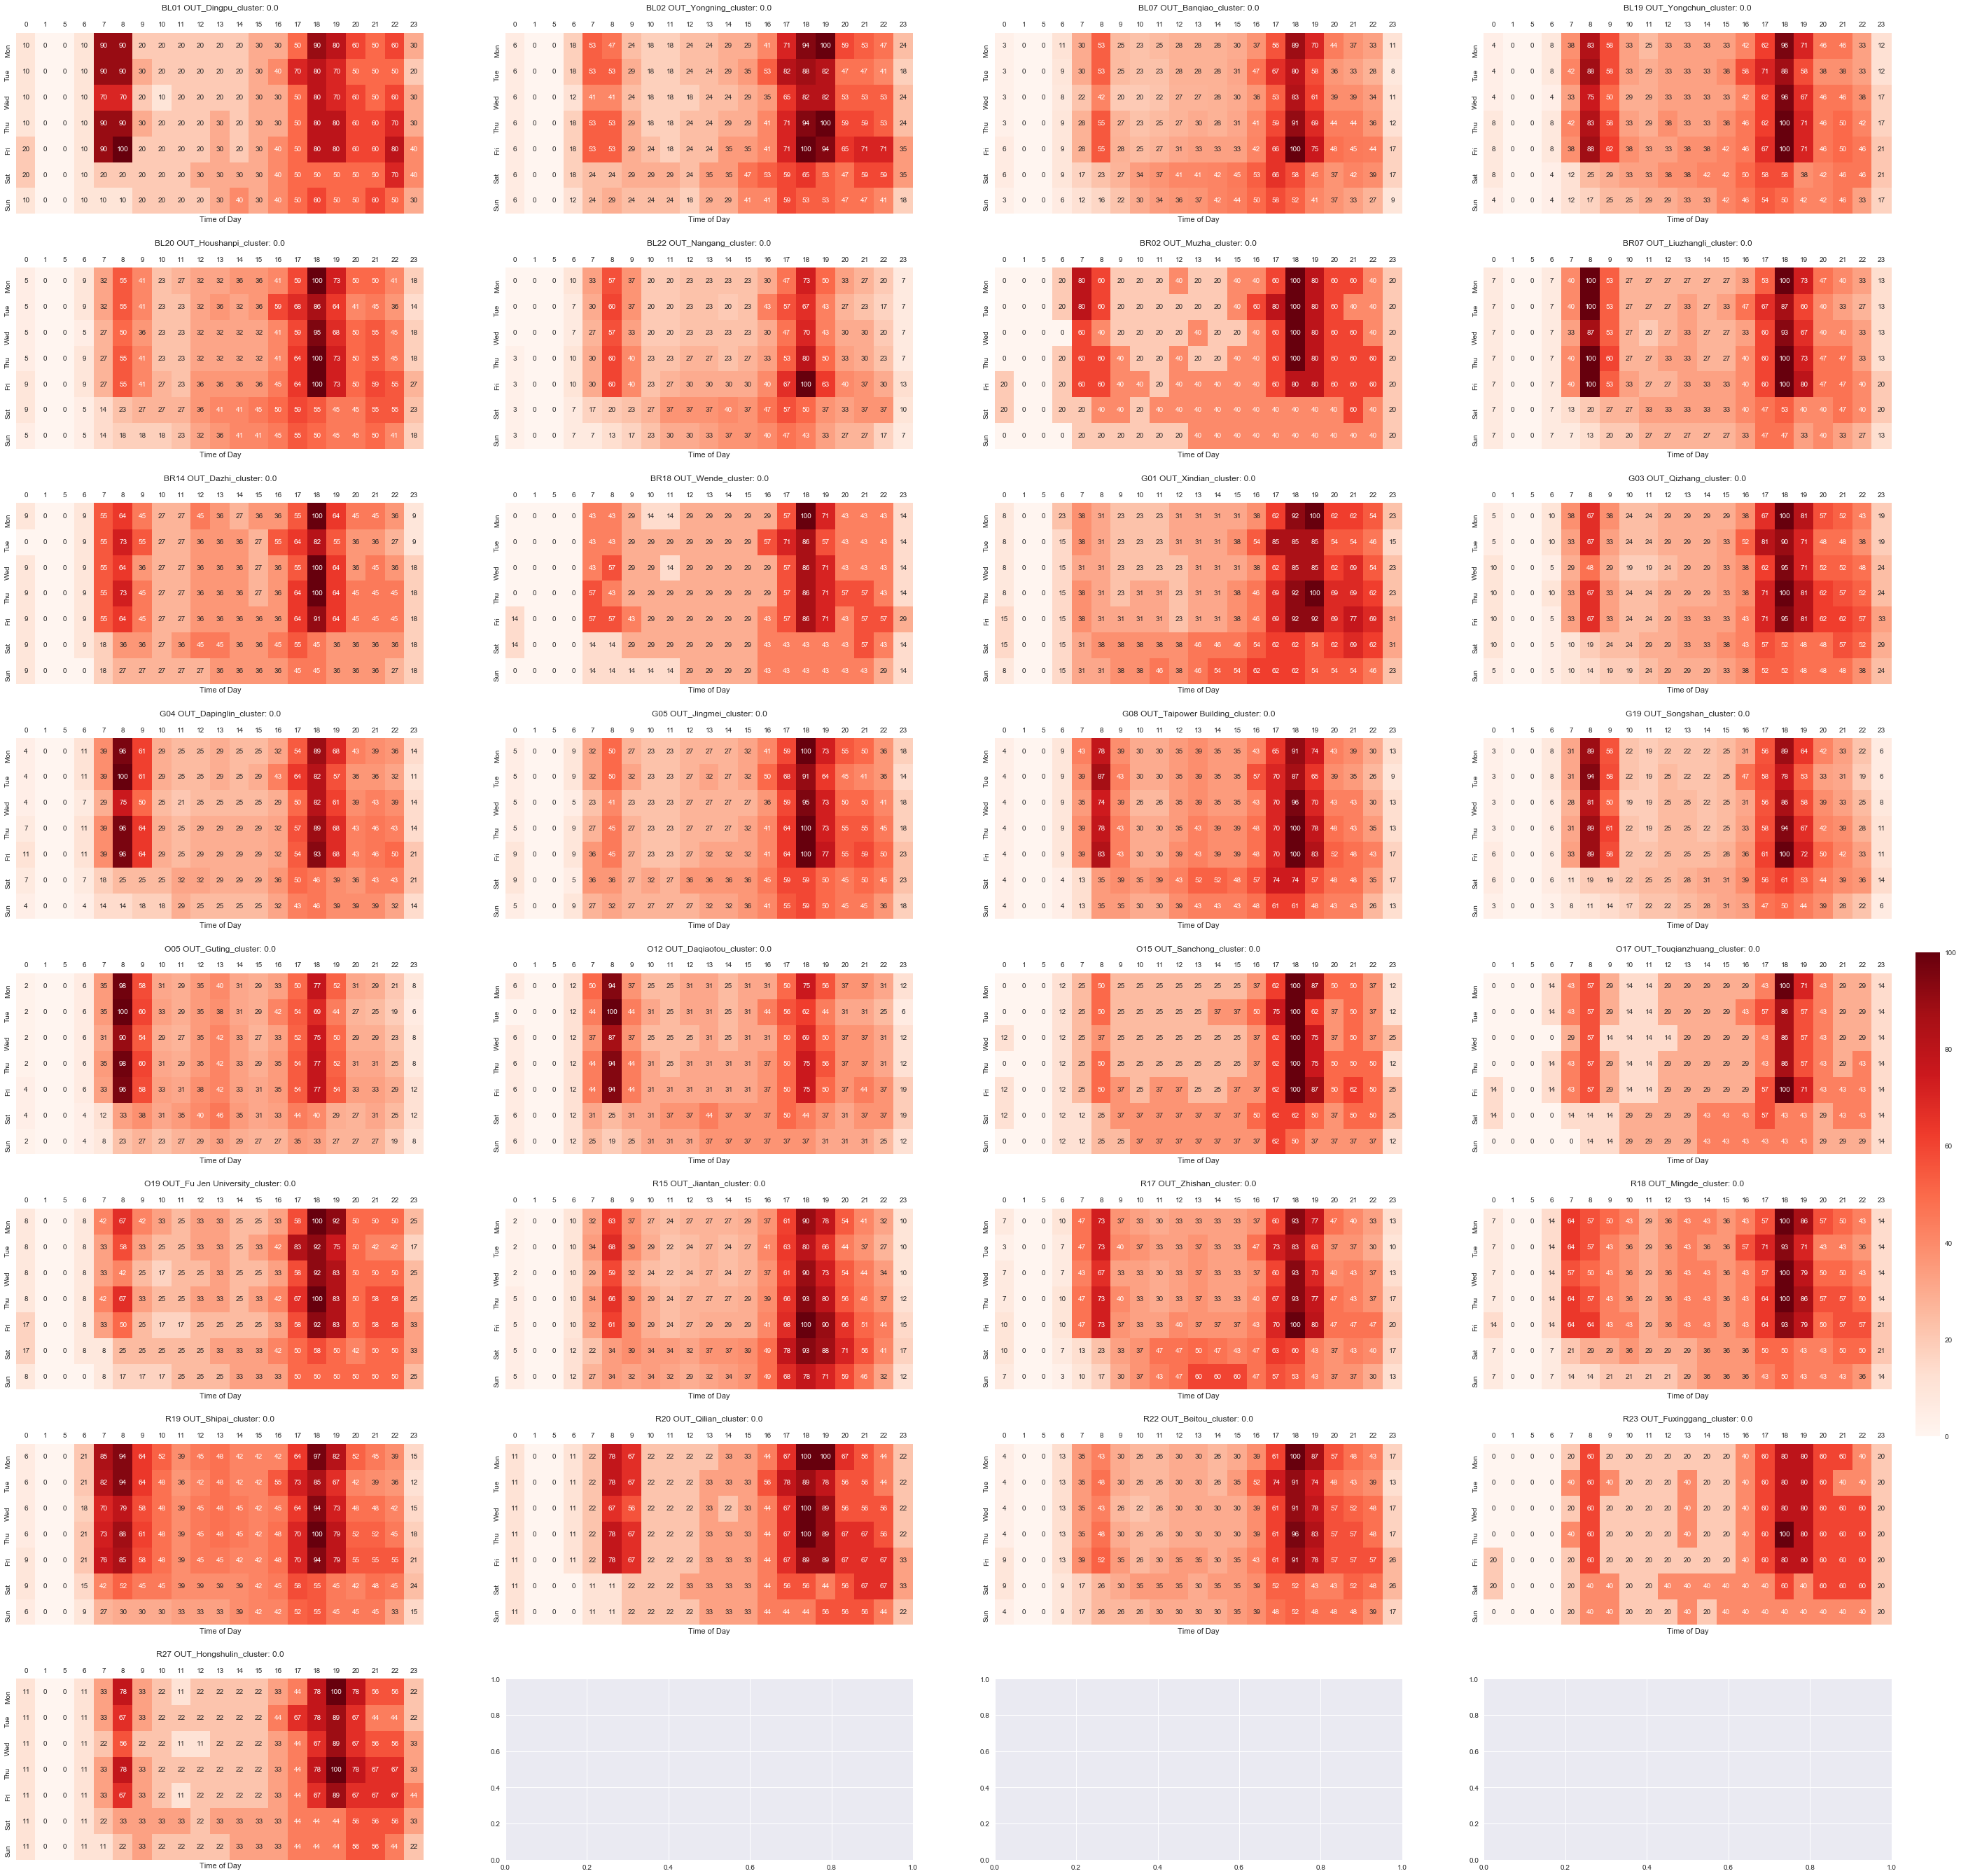

In [8]:
#show one cluster of heatmap as an example
heat_map2(df_km_dict,4,'Reds','x','.','example')

In [9]:
#2.2 LINE GRAPHS

#2.2.1
#Since there are 147 hours in a week in MRT data (21hr/day*7days),
#we need to put 3 more hours in each day, giving a 0 value each(2~4 a.m.).
def line_graph_xlabel():
    result = []
    for i in range(168):
        result.append(i)
    return result

def df_reformat_for_line(df):
    result_df = df.copy()
    insert_value = []
    for i in range(df.shape[0]):
        insert_value.append(0)
    # 7 for Monday to Sunday, 3 for 2,3,4 hour
    for i in range(7):
        for j in range(3):
            idx = (24*i)+2 #0,1,"2","3","4",5,6,7,8
            result_df.insert(loc=idx, column='{}_{}'.format(i,j), value=insert_value)
            
    rename_cols = []
    for i in range(168):
        rename_cols.append(i)
    rename_cols.append('cluster')
    result_df.columns = rename_cols   
    return result_df

#2.2.2 Calculate mean value for each hour in the given cluster
def cluster_mean_dict(df):
    result_dict = {}
    for cluster in df['cluster'].unique():
        result_dict[cluster] = df[df['cluster']==cluster].iloc[:,:-1].mean() #ignore last column, which is cluster group
    return result_dict

#2.2.3 Create a dictionary with cluster as keys, which contains a lists that consist of station dictionarys.
def cluster_group_dict_list_format(df):
    group_dict = {}
    for station in df.index:
        station_group = df.loc[station][-1]
        station_dict = {}
        station_dict[station] = df.loc[station][:-1]
        group_dict.setdefault(station_group, []).append(station_dict)
    return group_dict


def line_graph(group_dict,cluster_mean_dict,mean_color,file_name,saved_folder):
    #creating x_ticks
    x_labels = line_graph_xlabel()
    #deciding number of rows for the figure
    if len(group_dict.keys()) % 2 == 0:
        heigh = int(len(group_dict.keys())/2)
    else:
        heigh = int(len(group_dict.keys())/2) + 1

    fig,ax = plt.subplots(heigh,2,figsize=(16*2,5*heigh))
    fig.subplots_adjust(hspace = .2)

    for cluster in group_dict:
        #setting location for subplots
        location_c = int(cluster%2)
        location_r = int(cluster/2)
        try:
            for i in range(len(group_dict[cluster])):       
                for k,v in group_dict[cluster][i].items():
                    ax[location_r,location_c].set_title('Cluster: {}'.format(cluster),y=1.03)
                    ax[location_r,location_c].plot(x_labels,v,color='#d9d9d9', label = '_nolegend_')           
            ax[location_r,location_c].plot(x_labels,cluster_mean_dict[cluster],color=mean_color, label='Cluster avg.')

            #adding vertical lines
            weekday = ['Mon Noon','Tue Noon','Wed Noon','Thu Noon','Fri Noon','Sat Noon','Sun Noon']

            for i in range(0,168,24): # 168=24hour*7weekday
                ax[location_r,location_c].axvline(x=i, color='k', linestyle='--',linewidth=1.2)
                ax[location_r,location_c].text(i+8,0,weekday[int(i/24)],color=(0.3,0.3,0.3))
            #last line on the right side
            ax[location_r,location_c].axvline(x=167, color='k', linestyle='--',linewidth=1)

            for i in range(12,168,24):
                ax[location_r,location_c].axvline(x=i, color=(0.45,0.45,0.45), linestyle='--',linewidth=1)

            #turning off x ticks    
            ax[location_r,location_c].tick_params(
                    axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False)
            ax[location_r,location_c].legend()
            
        except IndexError:
            for i in range(len(group_dict[cluster])):       
                for k,v in group_dict[cluster][i].items():
                    ax[i].set_title('Cluster: {}'.format(cluster))
                    ax[i].plot(x_labels,v,color='#d9d9d9')           
                    #ax[location_r,location_c].legend()
            ax[i].plot(x_labels,cluster_mean_dict[cluster],color=mean_color)

            #adding vertical lines
            weekday = ['Mon Noon','Tue Noon','Wed Noon','Thu Noon','Fri Noon','Sat Noon','Sun Noon']
            for i in range(len(group_dict[cluster])):
                for j in range(0,168,24): # 168=24*7
                    ax[i].axvline(x=j, color='k', linestyle='--',linewidth=1.2)
                    ax[i].text(j+8,0,weekday[int(i/24)],color=(0.3,0.3,0.3))
                #last line on the right side
                ax[i].axvline(x=167, color='k', linestyle='--',linewidth=1)

                for j in range(12,168,24):
                    ax[i].axvline(x=j, color=(0.45,0.45,0.45), linestyle='--',linewidth=1)

                #turning off x ticks    
                ax[i].tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
            
    plt.savefig('{}/{}.png'.format(saved_folder,file_name),
                bbox_inches='tight')
    

In [10]:
re_format = df_reformat_for_line(df_out)
re_format.head()

0    1  2  3  4    5     6     7     8     9   ...      159  \
BL01 OUT  0.10  0.0  0  0  0  0.0  0.10  0.90  0.90  0.20   ...     0.30   
BL02 OUT  0.06  0.0  0  0  0  0.0  0.18  0.53  0.47  0.24   ...     0.41   
BL03 OUT  0.10  0.0  0  0  0  0.0  0.10  0.30  0.40  0.20   ...     0.30   
BL04 OUT  0.06  0.0  0  0  0  0.0  0.03  0.14  0.20  0.14   ...     0.26   
BL05 OUT  0.07  0.0  0  0  0  0.0  0.10  0.37  0.43  0.37   ...     0.27   

           160   161   162   163   164   165   166   167  cluster  
BL01 OUT  0.40  0.50  0.60  0.50  0.50  0.60  0.50  0.30        0  
BL02 OUT  0.41  0.59  0.53  0.53  0.47  0.47  0.41  0.18        0  
BL03 OUT  0.40  0.50  0.50  0.40  0.40  0.50  0.40  0.20        1  
BL04 OUT  0.34  0.40  0.46  0.37  0.40  0.46  0.43  0.20        1  
BL05 OUT  0.30  0.40  0.40  0.33  0.33  0.37  0.33  0.13        1  

[5 rows x 169 columns]

In [11]:
line_group_dict = cluster_group_dict_list_format(re_format)
line_group_dict[0][0] #First 0 as one of clusters, second 0 as list index

{'BL01 OUT': 0      0.1
 1      0.0
 2      0.0
 3      0.0
 4      0.0
 5      0.0
 6      0.1
 7      0.9
 8      0.9
 9      0.2
 10     0.2
 11     0.2
 12     0.2
 13     0.2
 14     0.2
 15     0.3
 16     0.3
 17     0.5
 18     0.9
 19     0.8
 20     0.6
 21     0.5
 22     0.6
 23     0.3
 24     0.1
 25     0.0
 26     0.0
 27     0.0
 28     0.0
 29     0.0
       ... 
 138    0.5
 139    0.5
 140    0.5
 141    0.5
 142    0.7
 143    0.4
 144    0.1
 145    0.0
 146    0.0
 147    0.0
 148    0.0
 149    0.0
 150    0.1
 151    0.1
 152    0.1
 153    0.2
 154    0.2
 155    0.2
 156    0.2
 157    0.3
 158    0.4
 159    0.3
 160    0.4
 161    0.5
 162    0.6
 163    0.5
 164    0.5
 165    0.6
 166    0.5
 167    0.3
 Name: BL01 OUT, Length: 168, dtype: float64}

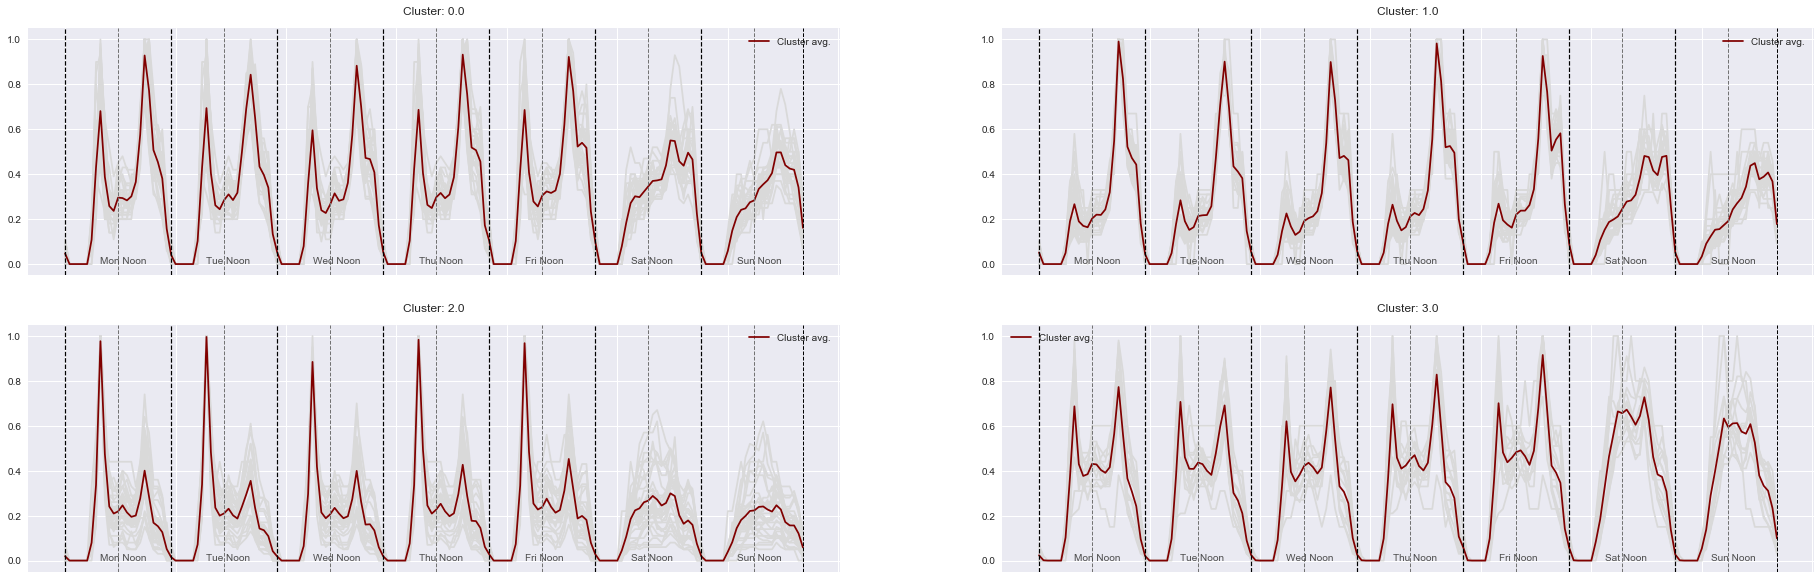

In [12]:
cluster_mean = cluster_mean_dict(re_format)
line_graph(line_group_dict,cluster_mean,'maroon','x','.')

<a id='3'></a>
### [Part 3 Module the Process](#0)
Combine the processes above into K_means_package which consists of:
- k_means_generator   : create K-means results
- cluster_station_dict: save result into a csv file
- line_graph_painter
- heat_map_painter

In [13]:

def k_means_generator(file_name,flow_direction,groups):
    df = pd.read_csv('{}.csv'.format(file_name),index_col=0)
    df = df.filter(regex='{}$'.format(flow_direction), axis=0)
    df = k_means_df(df,groups) #k_means_df(import_df, n_clusters)
    
    #df_list is for checking the result only, no other usage in this function
    df_list = k_means_list(df)
    print('Flow Directioin: {}'.format(flow_direction))
    for k,v in df_list.items():
        print('Cluster Group {} with {} stations'.format(k,len(df_list[k])))
    
    return df

# station list in each cluster (reference file)
def cluster_station_dict(df,file_name):
    line_group_dict = cluster_group_dict_list_format(df)
    cluster_station = {}
    for k,v in line_group_dict.items():
        for dict_ in v:
            for k_2,v_2 in dict_.items():
                cluster_station.setdefault(k, []).append(k_2)
                
    with open('{}.csv'.format(file_name), 'w') as f:  # Just use 'w' mode in 3.x
        writer = csv.writer(f)
        for key, value in cluster_station.items():
           writer.writerow([key, value])
        
    return cluster_station
    
# LINE GRAPH SUMUP   
def line_graph_painter(df,mean_color,file_name,saved_folder):
    re_format = df_reformat_for_line(df)
    line_group_dict = cluster_group_dict_list_format(re_format)
    #print(line_group_dict)
    cluster_mean = cluster_mean_dict(re_format)
    line_graph(line_group_dict,cluster_mean,mean_color,file_name,saved_folder)
    
# HEATMAP SUMUP
def heat_map_painter(df,col_num,color,file_name,saved_folder):
    df_list = k_means_list(df)
    heat_map2(df_list,col_num,color,file_name,saved_folder) #heat_map2(import_df, number of columns, color, file name)

#Combine processes above
def K_means_package(package_name,file_name,n_cluster,heatmap_cols):
    dirName = package_name
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " folder created ")
    else:    
        print("Directory " , dirName ,  " already exists")

    df_in = k_means_generator(file_name,'IN',n_cluster)
    df_out = k_means_generator(file_name,'OUT',n_cluster)
    
    df_in.to_csv('{}/k_pack_IN.csv'.format(package_name),encoding = 'utf-8')
    df_out.to_csv('{}/k_pack_OUT.csv'.format(package_name),encoding = 'utf-8')

    cluster_groups_in = cluster_station_dict(df_in,'cluster_group_IN')
    cluster_groups_out = cluster_station_dict(df_out,'cluster_group_OUT')

    line_graph_painter(df_in,'darkblue','All_in_lineGraph',package_name)
    line_graph_painter(df_out,'maroon','All_out_lineGraph',package_name)

    heat_map_painter(df_in,heatmap_cols,'Blues','All_in_heatmap',package_name)
    heat_map_painter(df_out,heatmap_cols,'Reds','All_out_heatmap',package_name)
  
    return df_in,df_out

Directory  notebook_illustration  folder created 
Flow Directioin: IN
Cluster Group 0.0 with 45 stations
Cluster Group 3.0 with 22 stations
Cluster Group 1.0 with 20 stations
Cluster Group 2.0 with 21 stations
Flow Directioin: OUT
Cluster Group 3.0 with 29 stations
Cluster Group 1.0 with 32 stations
Cluster Group 2.0 with 17 stations
Cluster Group 0.0 with 30 stations
processing cluster: 0,cluster length: 45
processing cluster: 3,cluster length: 22
processing cluster: 1,cluster length: 20
processing cluster: 2,cluster length: 21
processing cluster: 3,cluster length: 29
processing cluster: 1,cluster length: 32
processing cluster: 2,cluster length: 17
processing cluster: 0,cluster length: 30
processing 29 ax[7, 1]

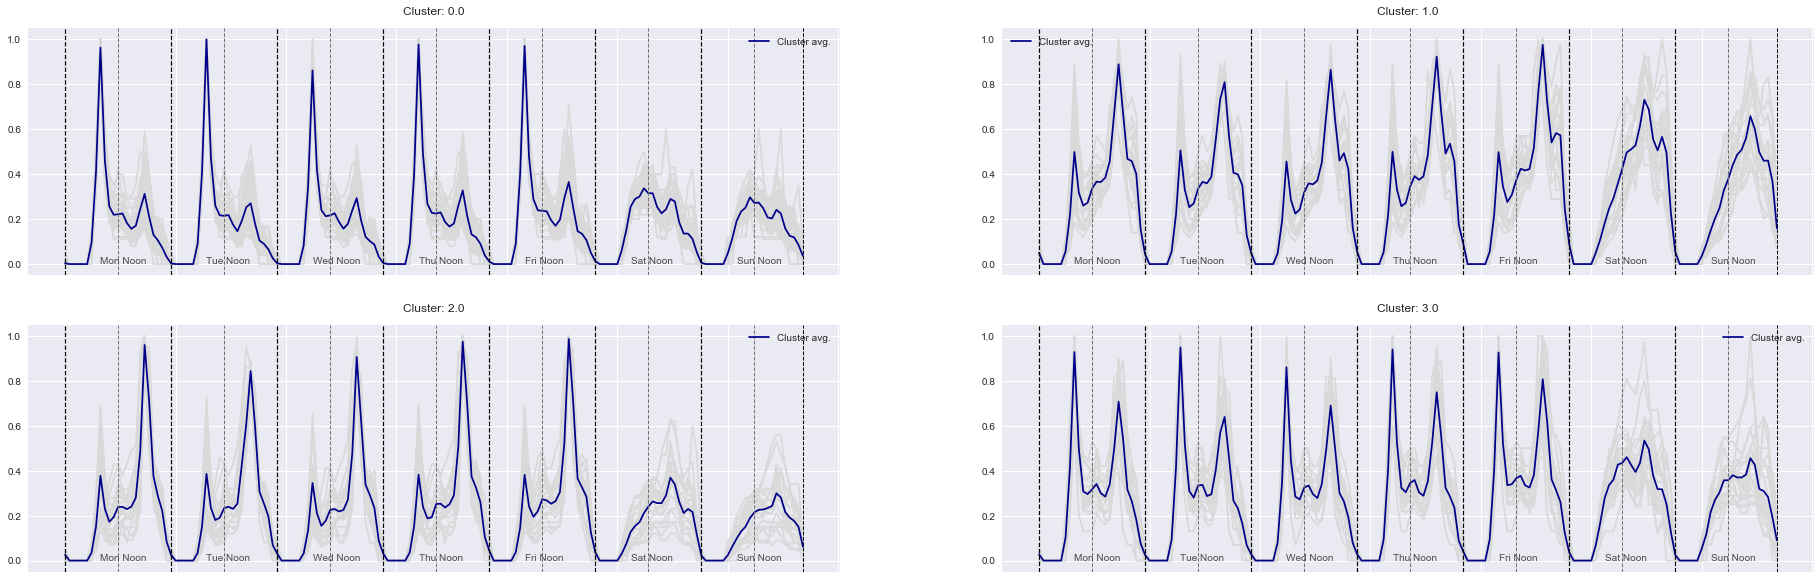

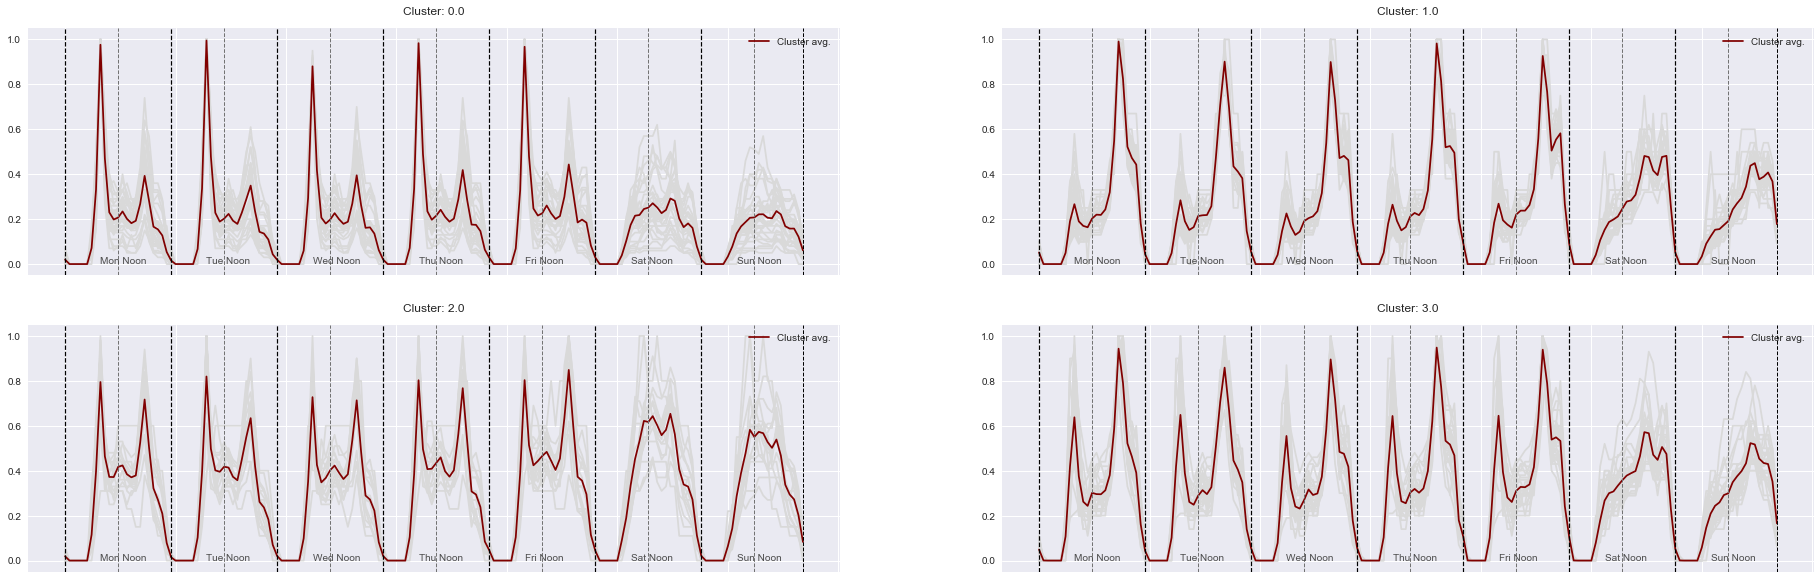

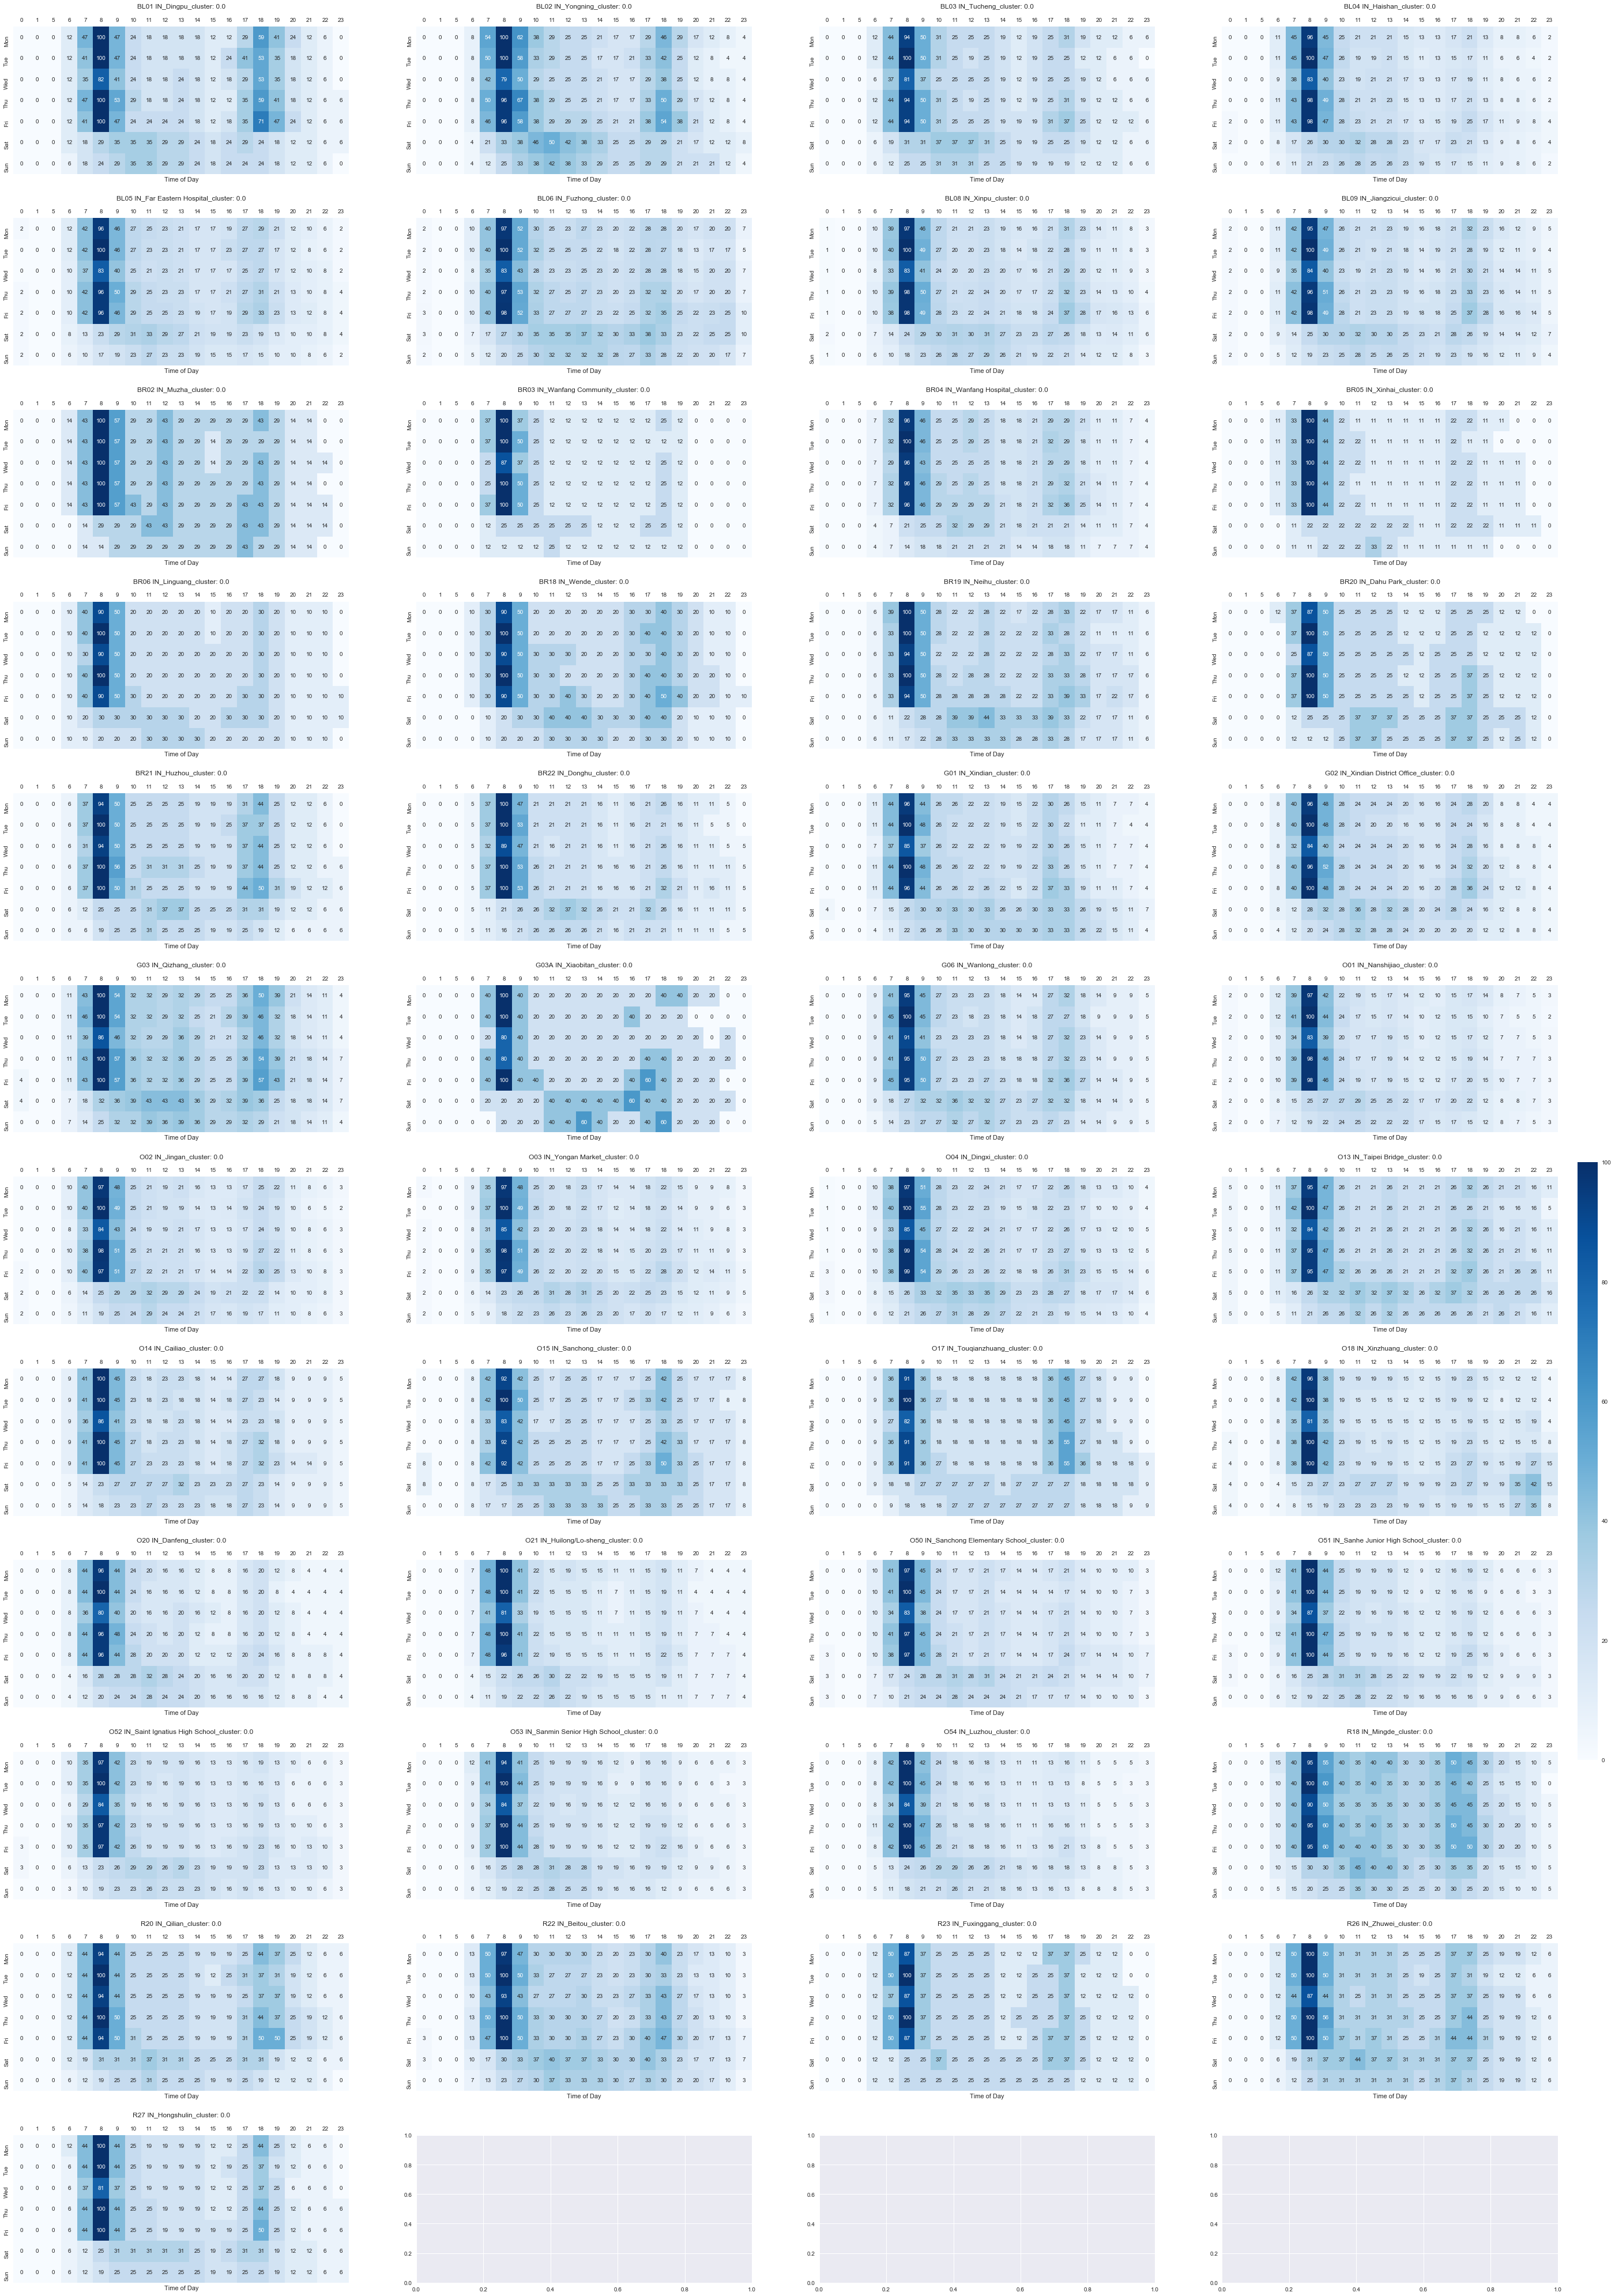

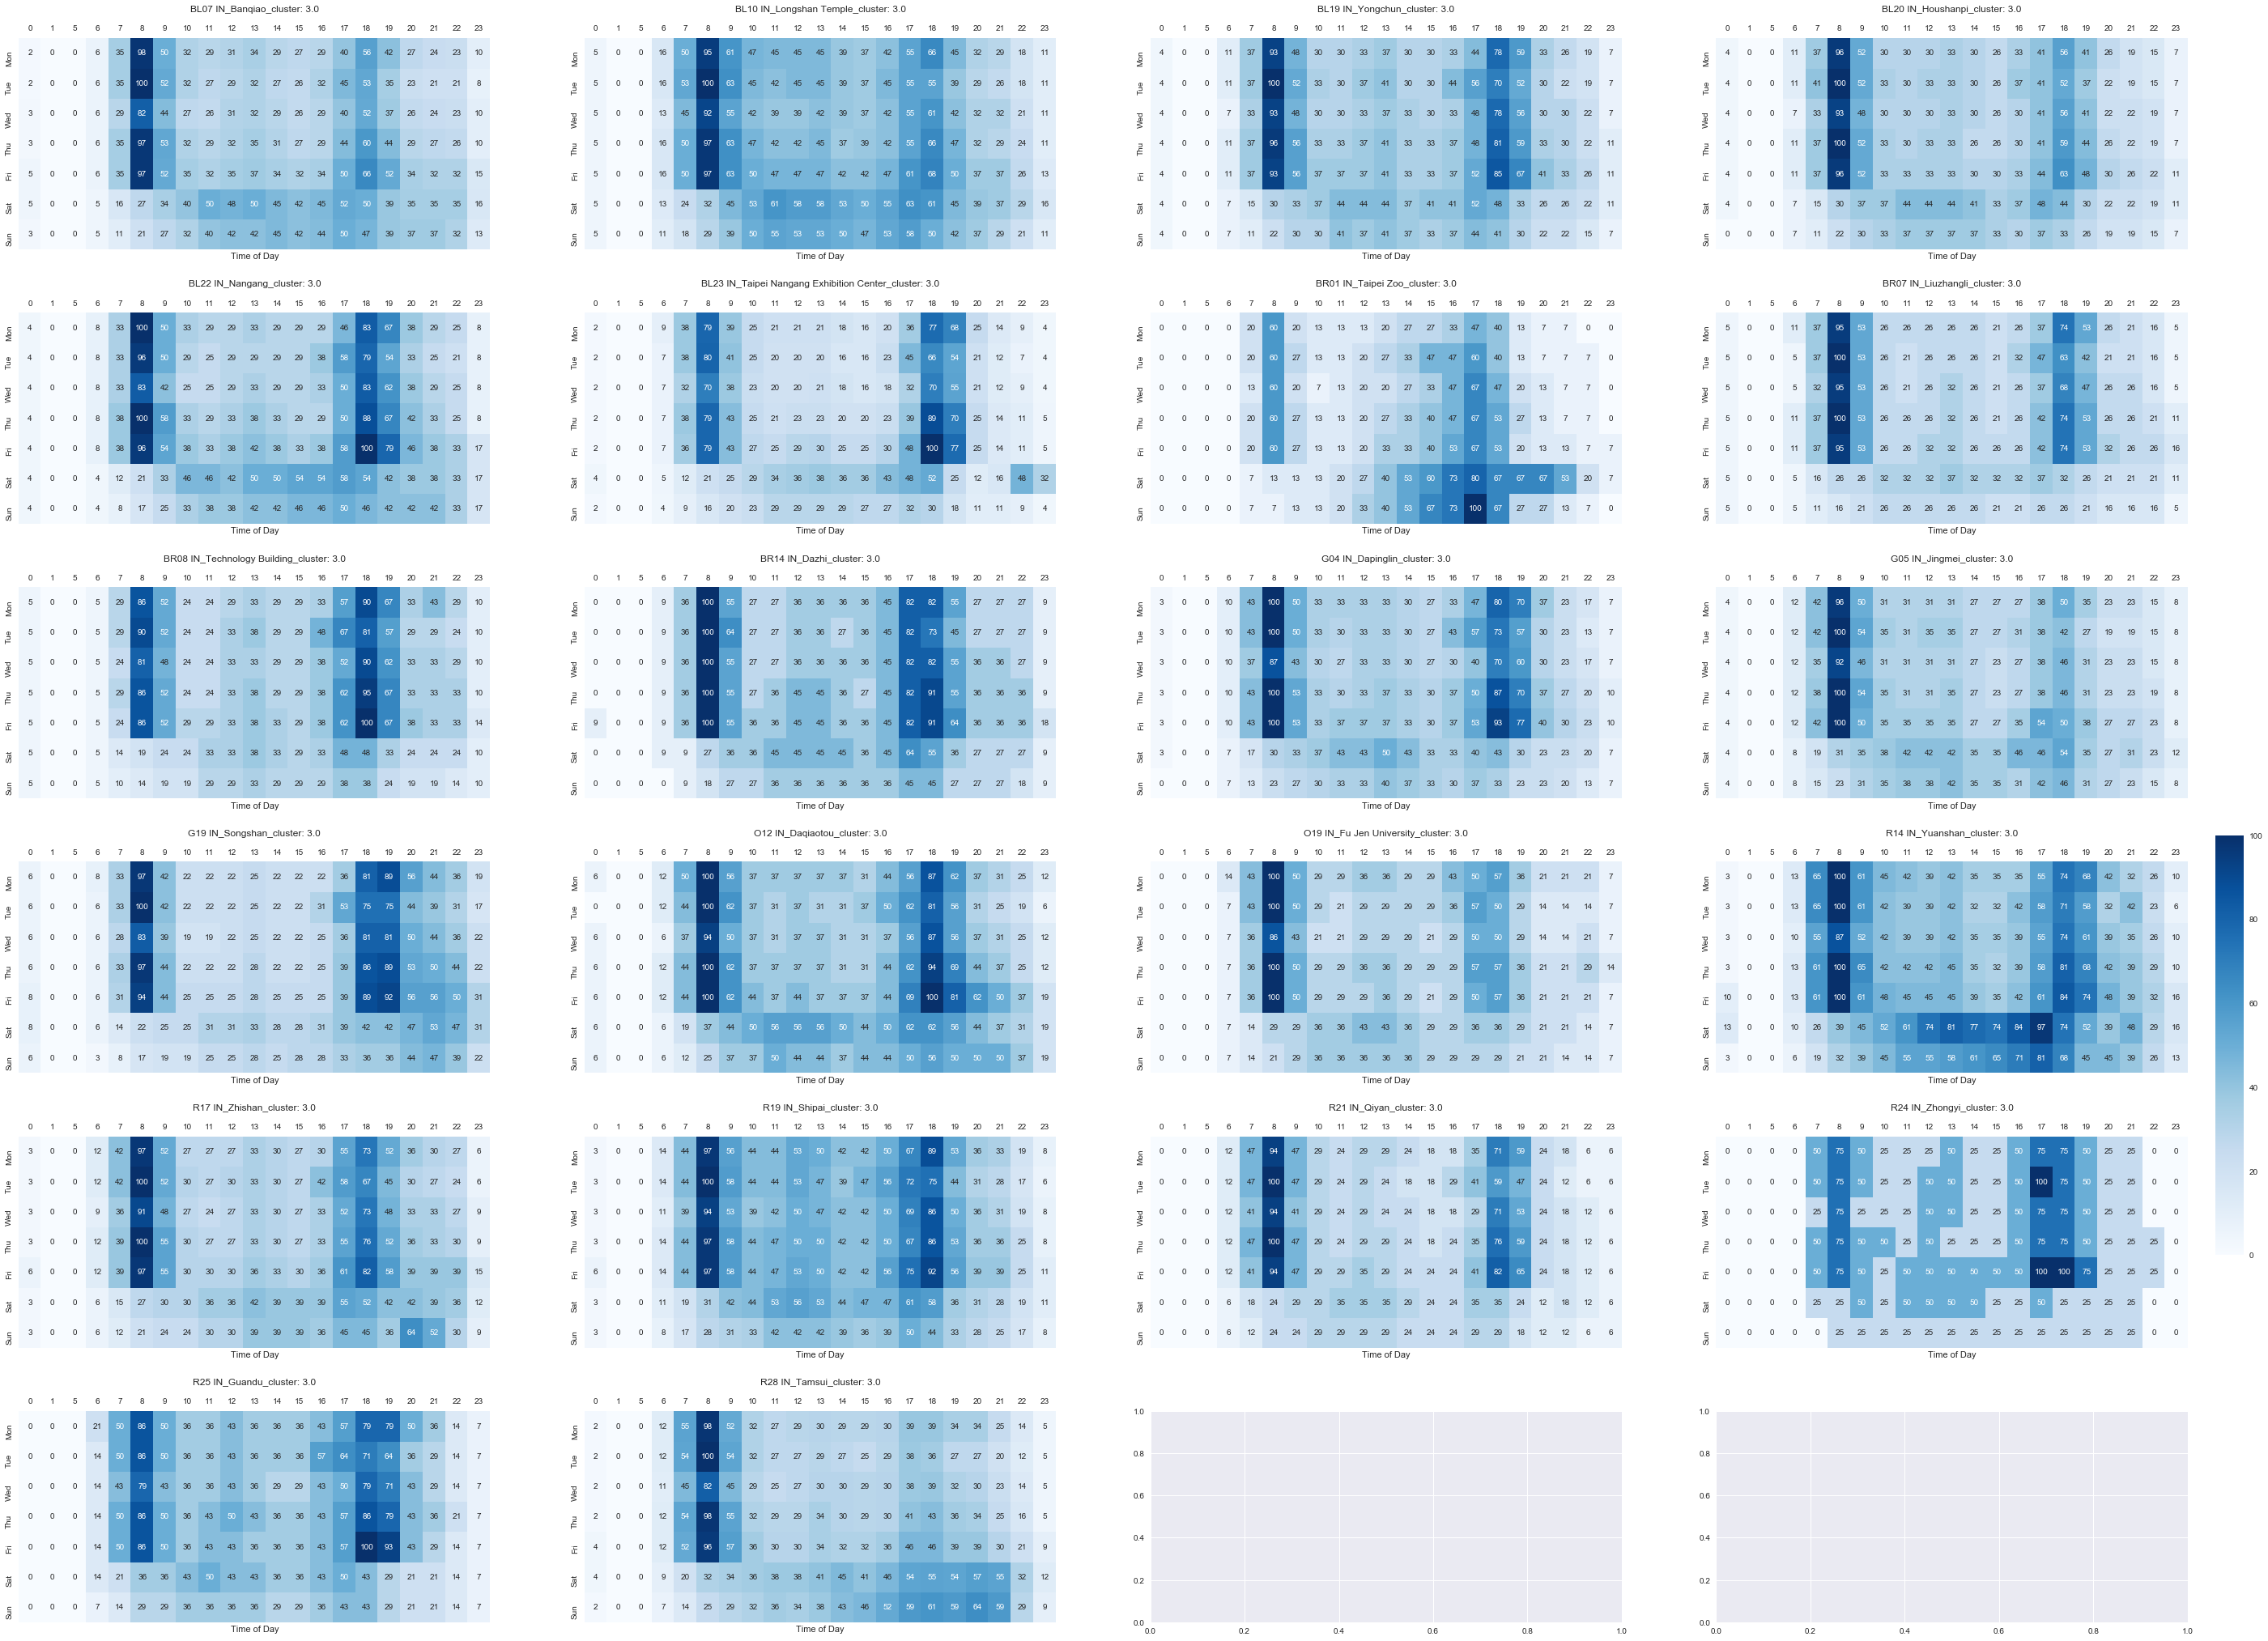

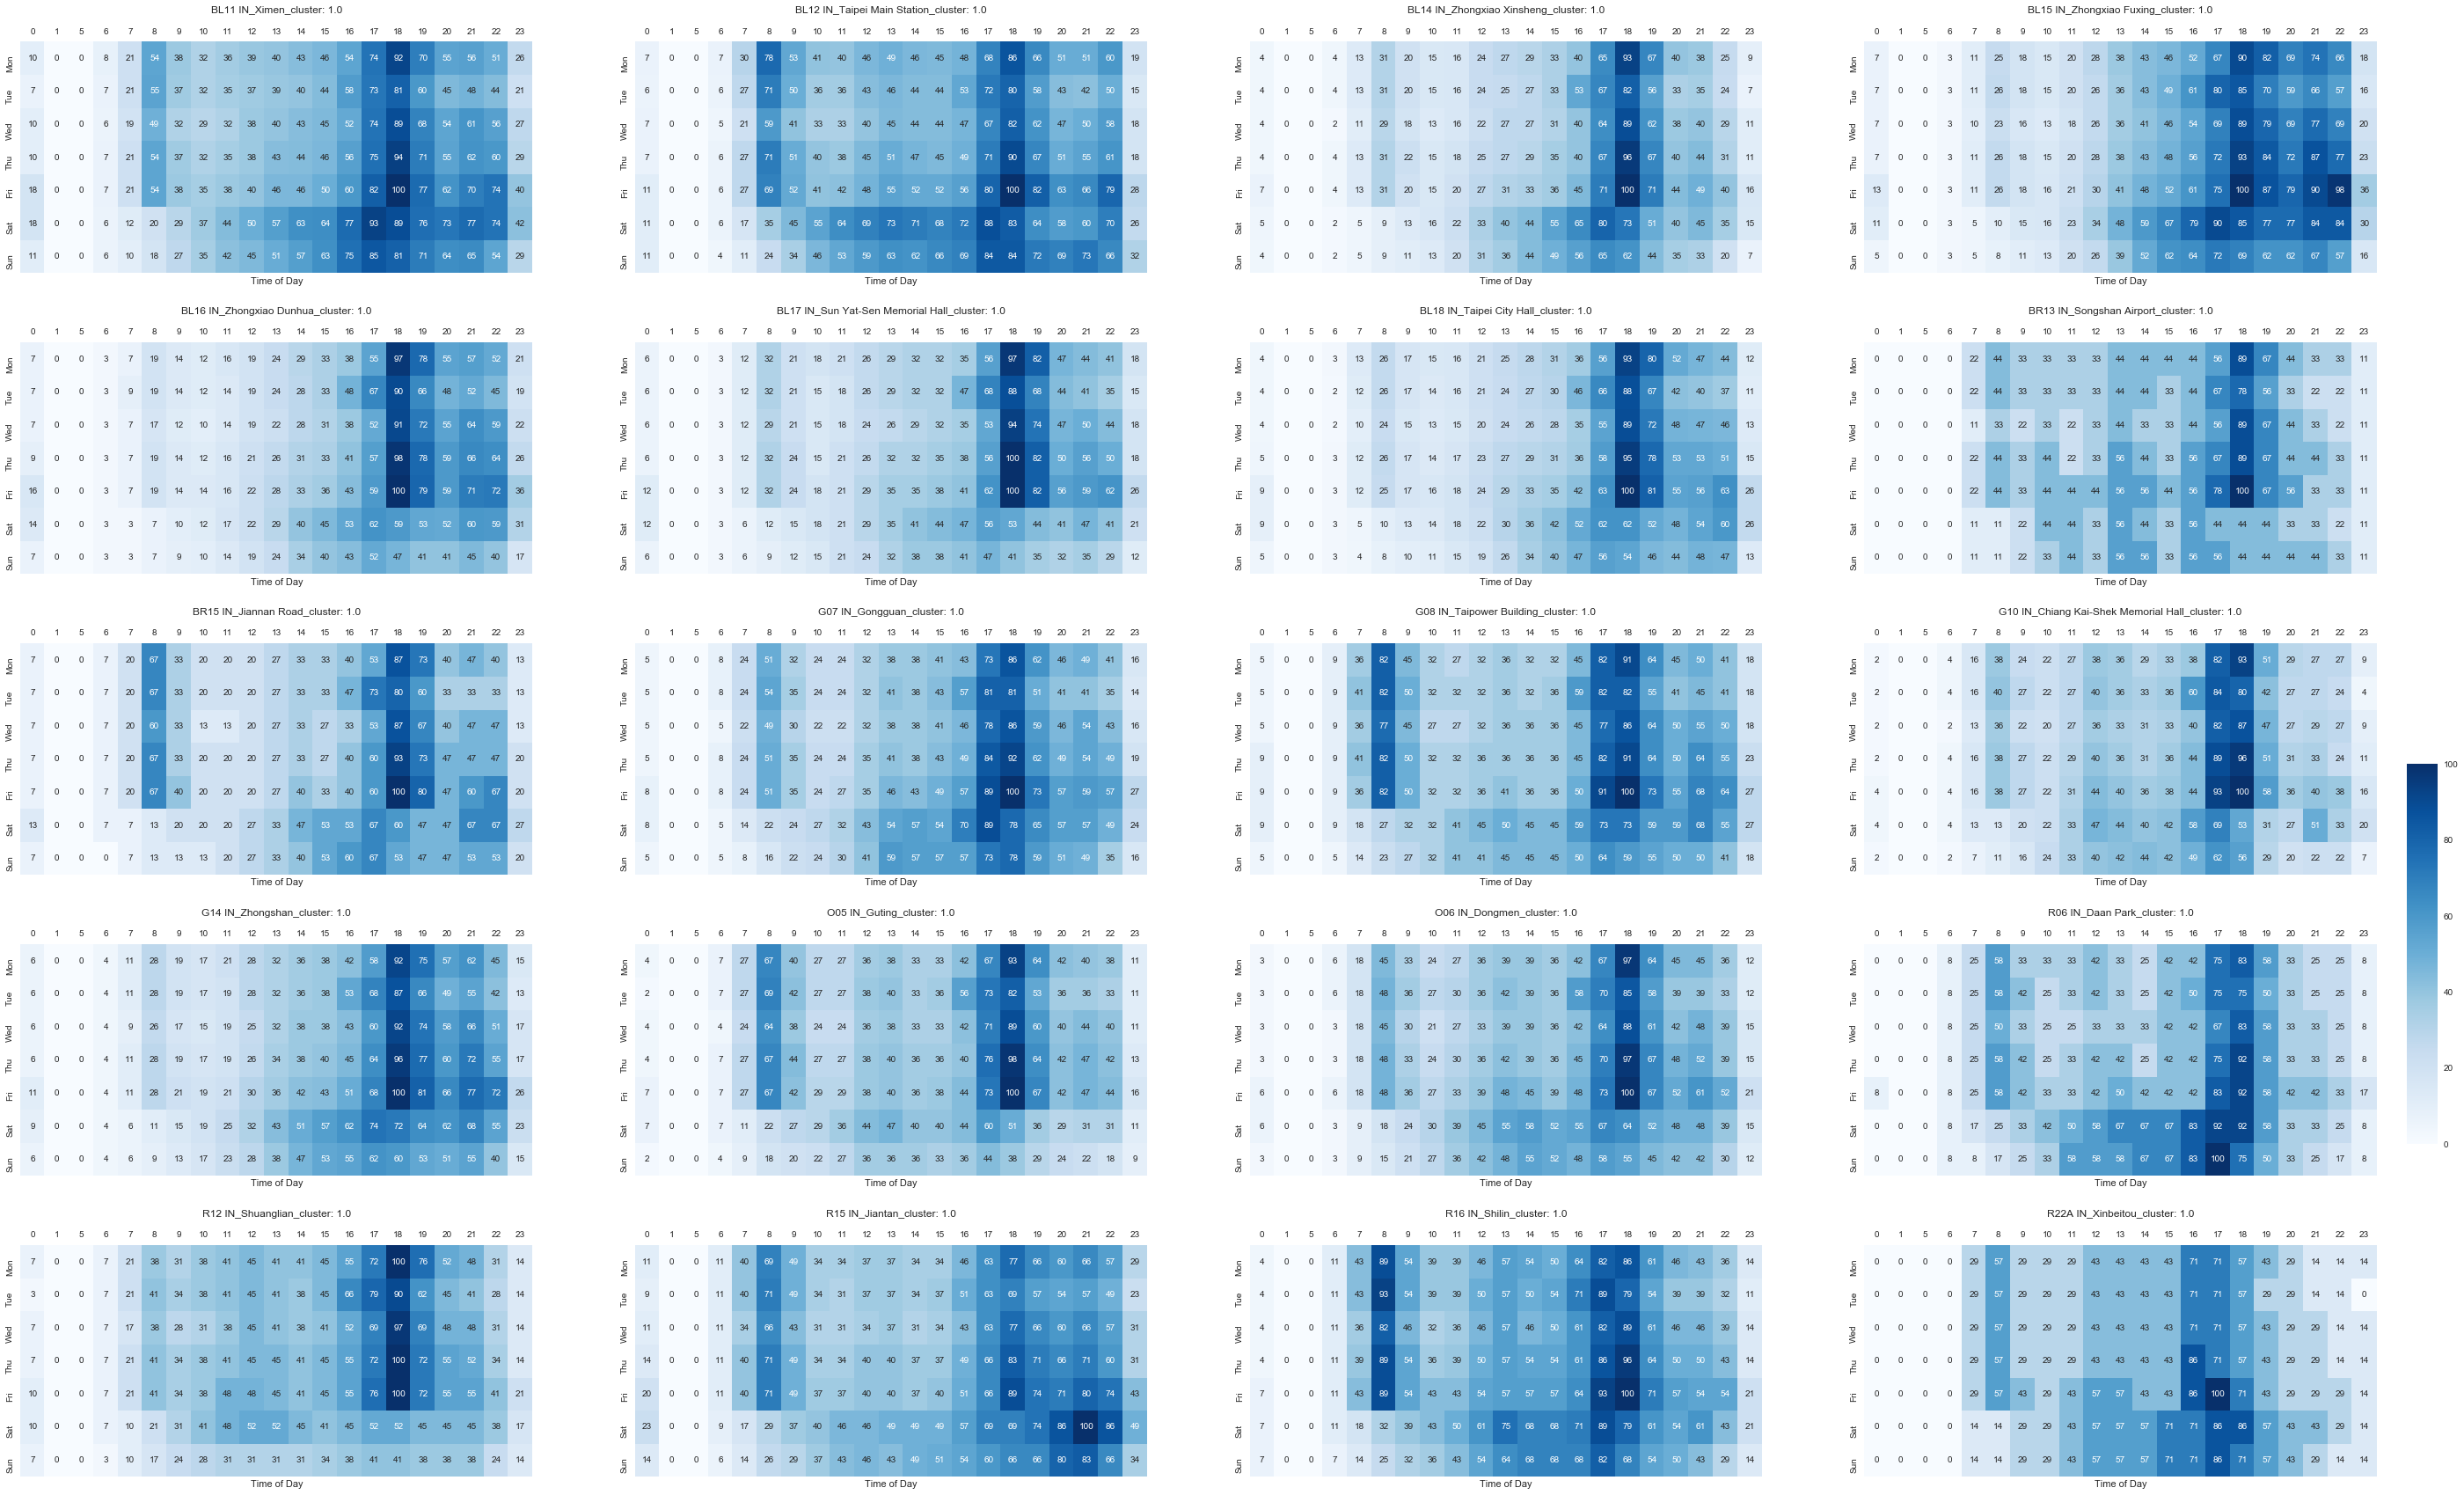

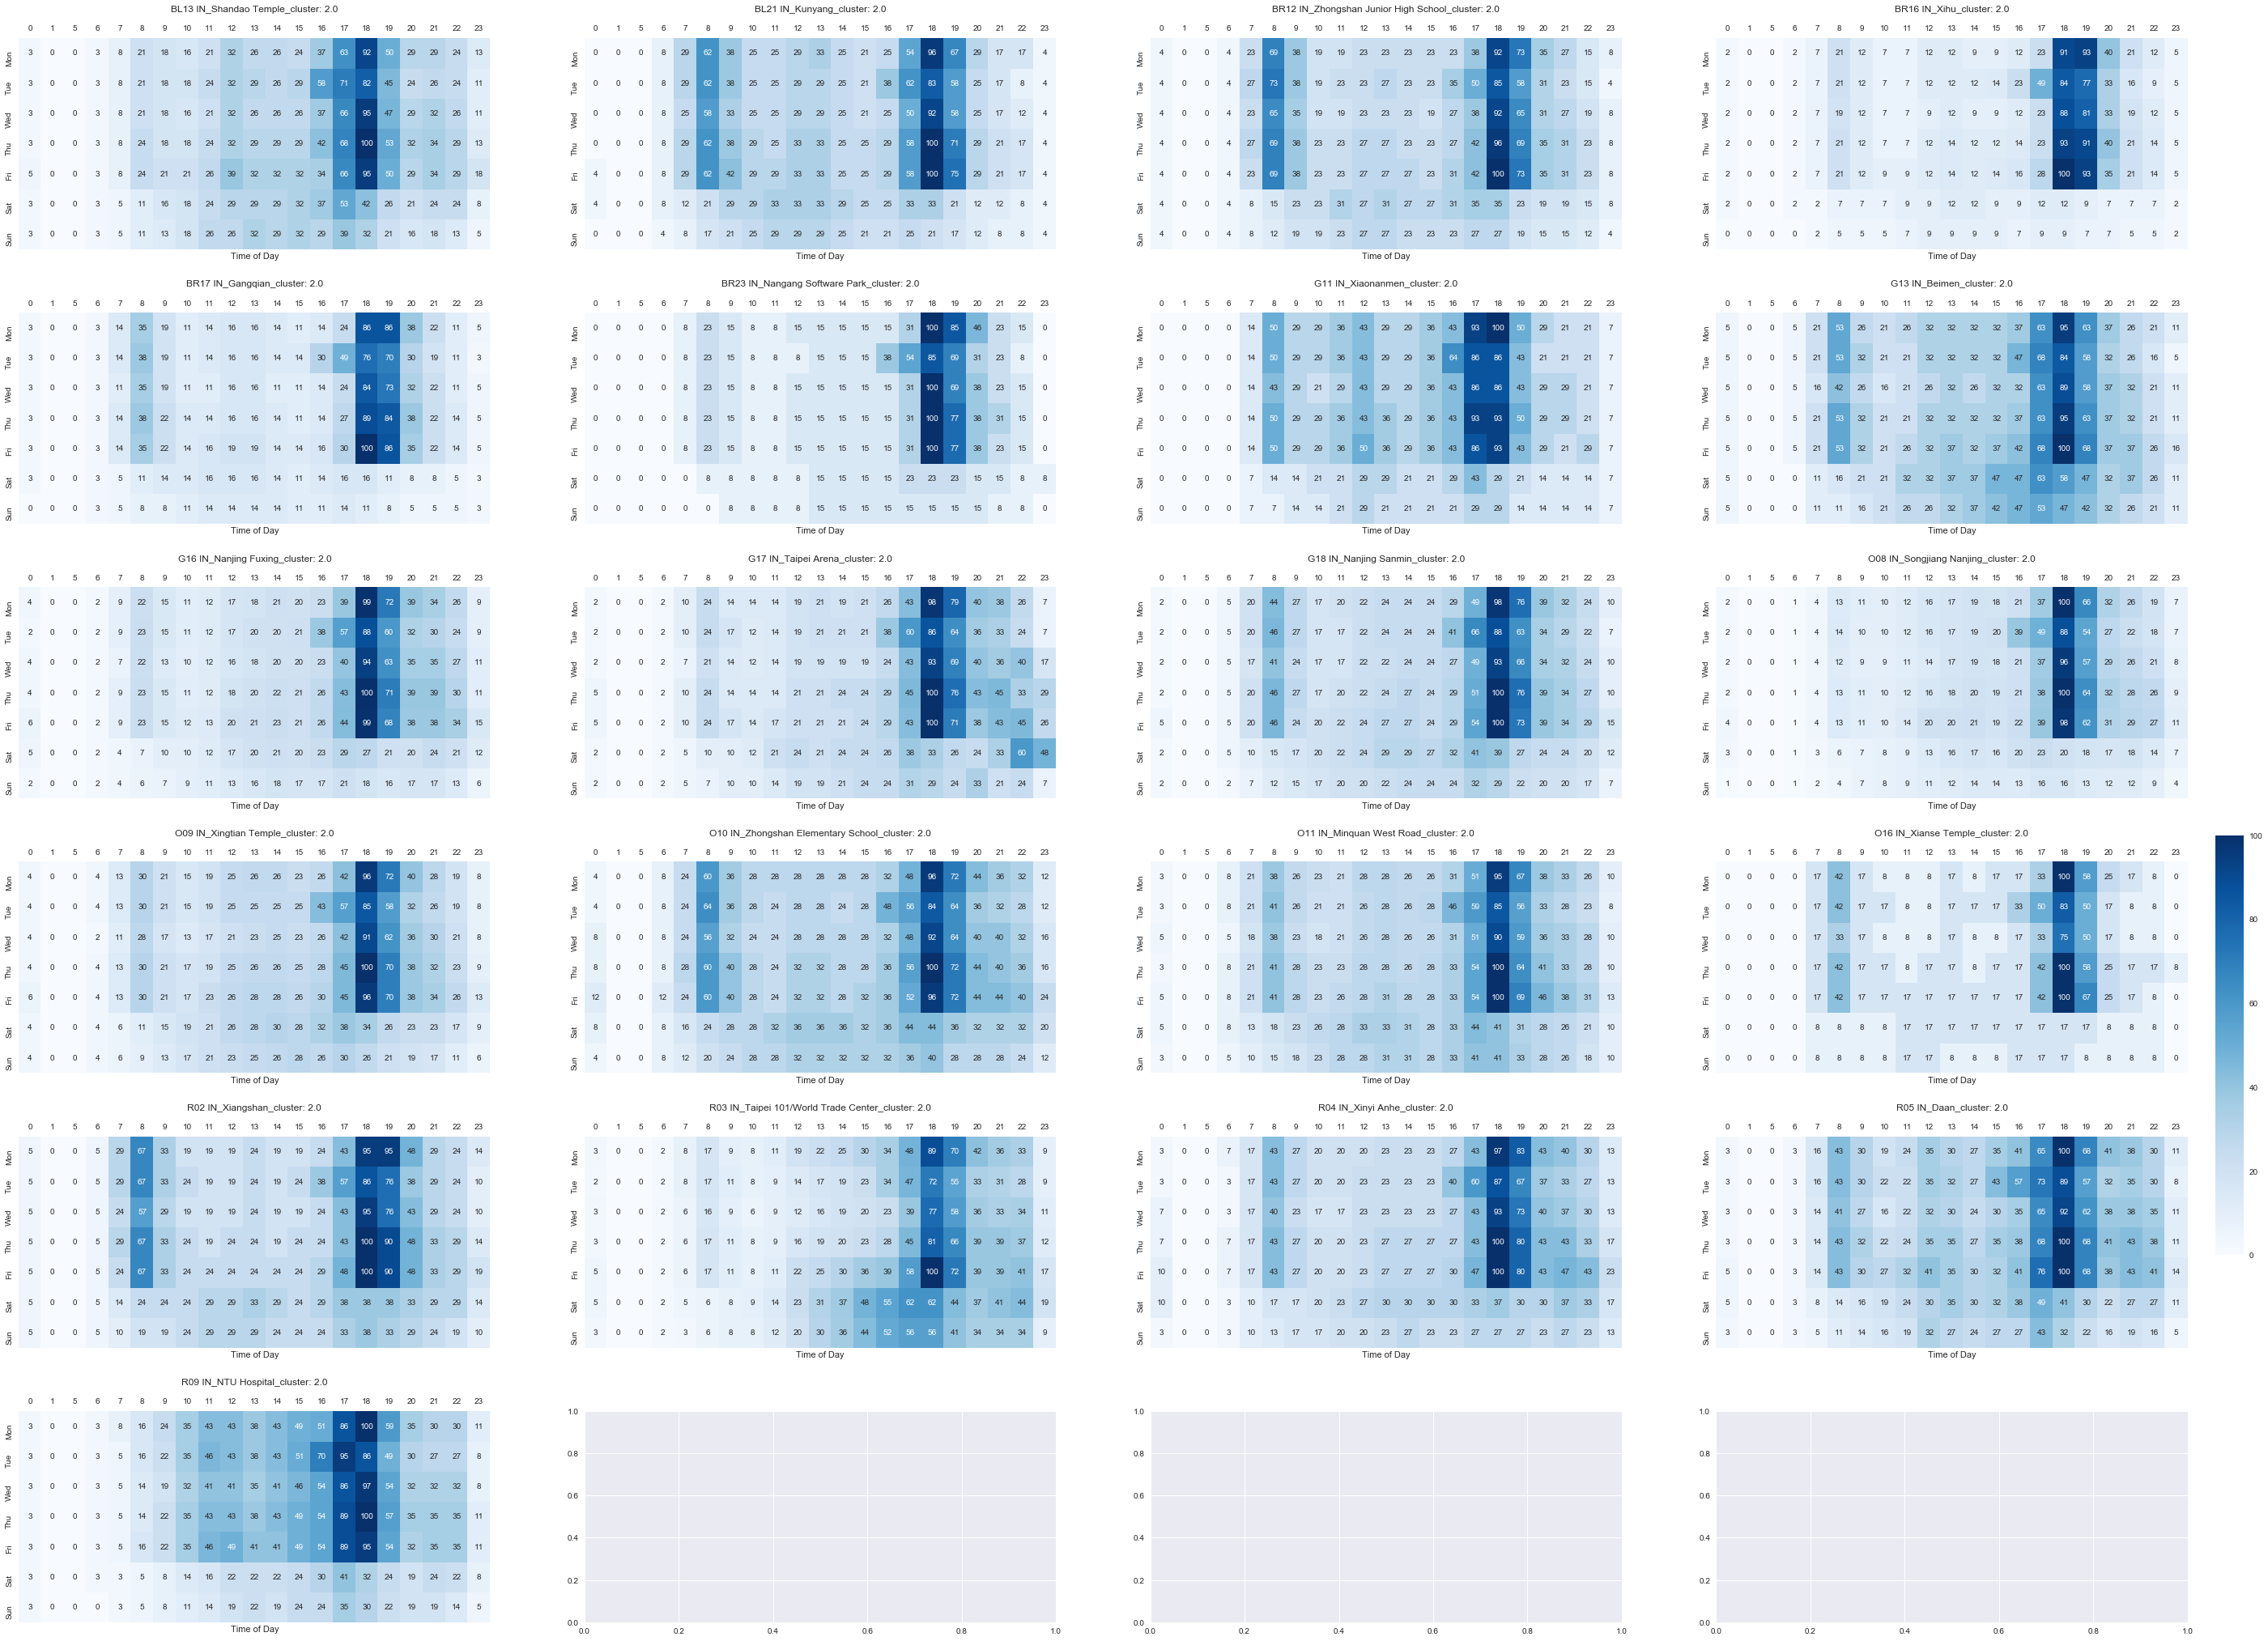

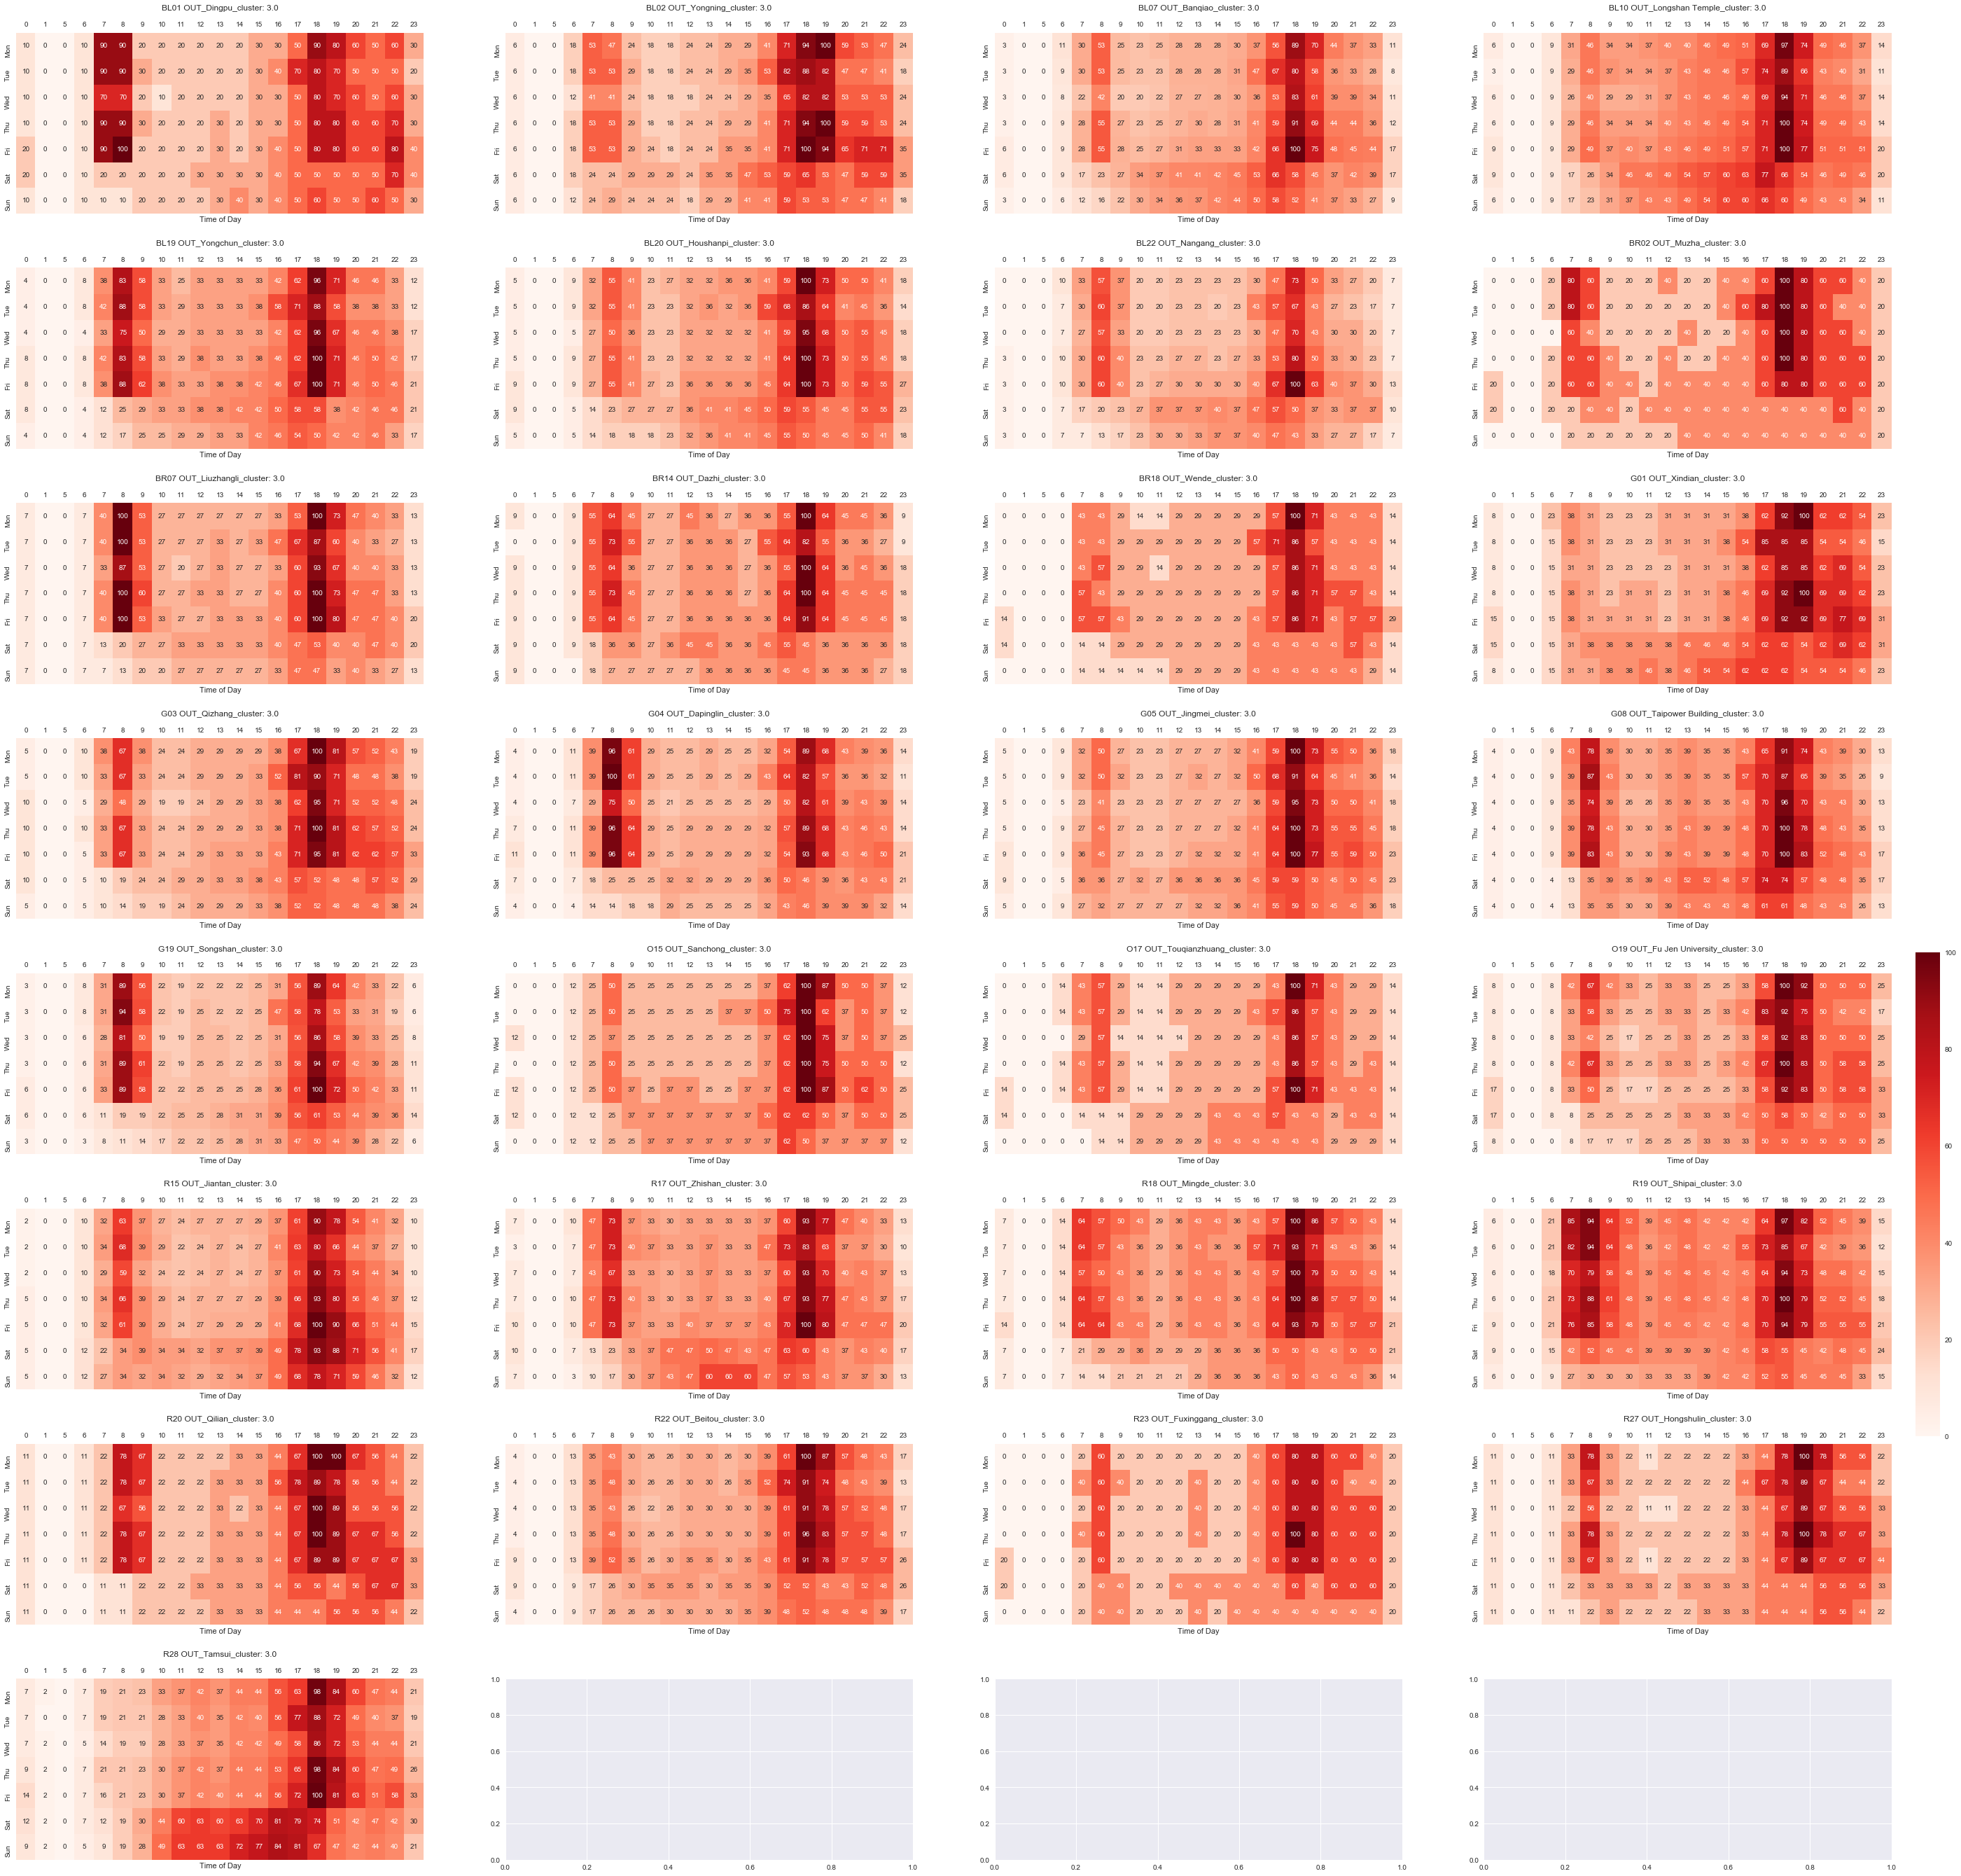

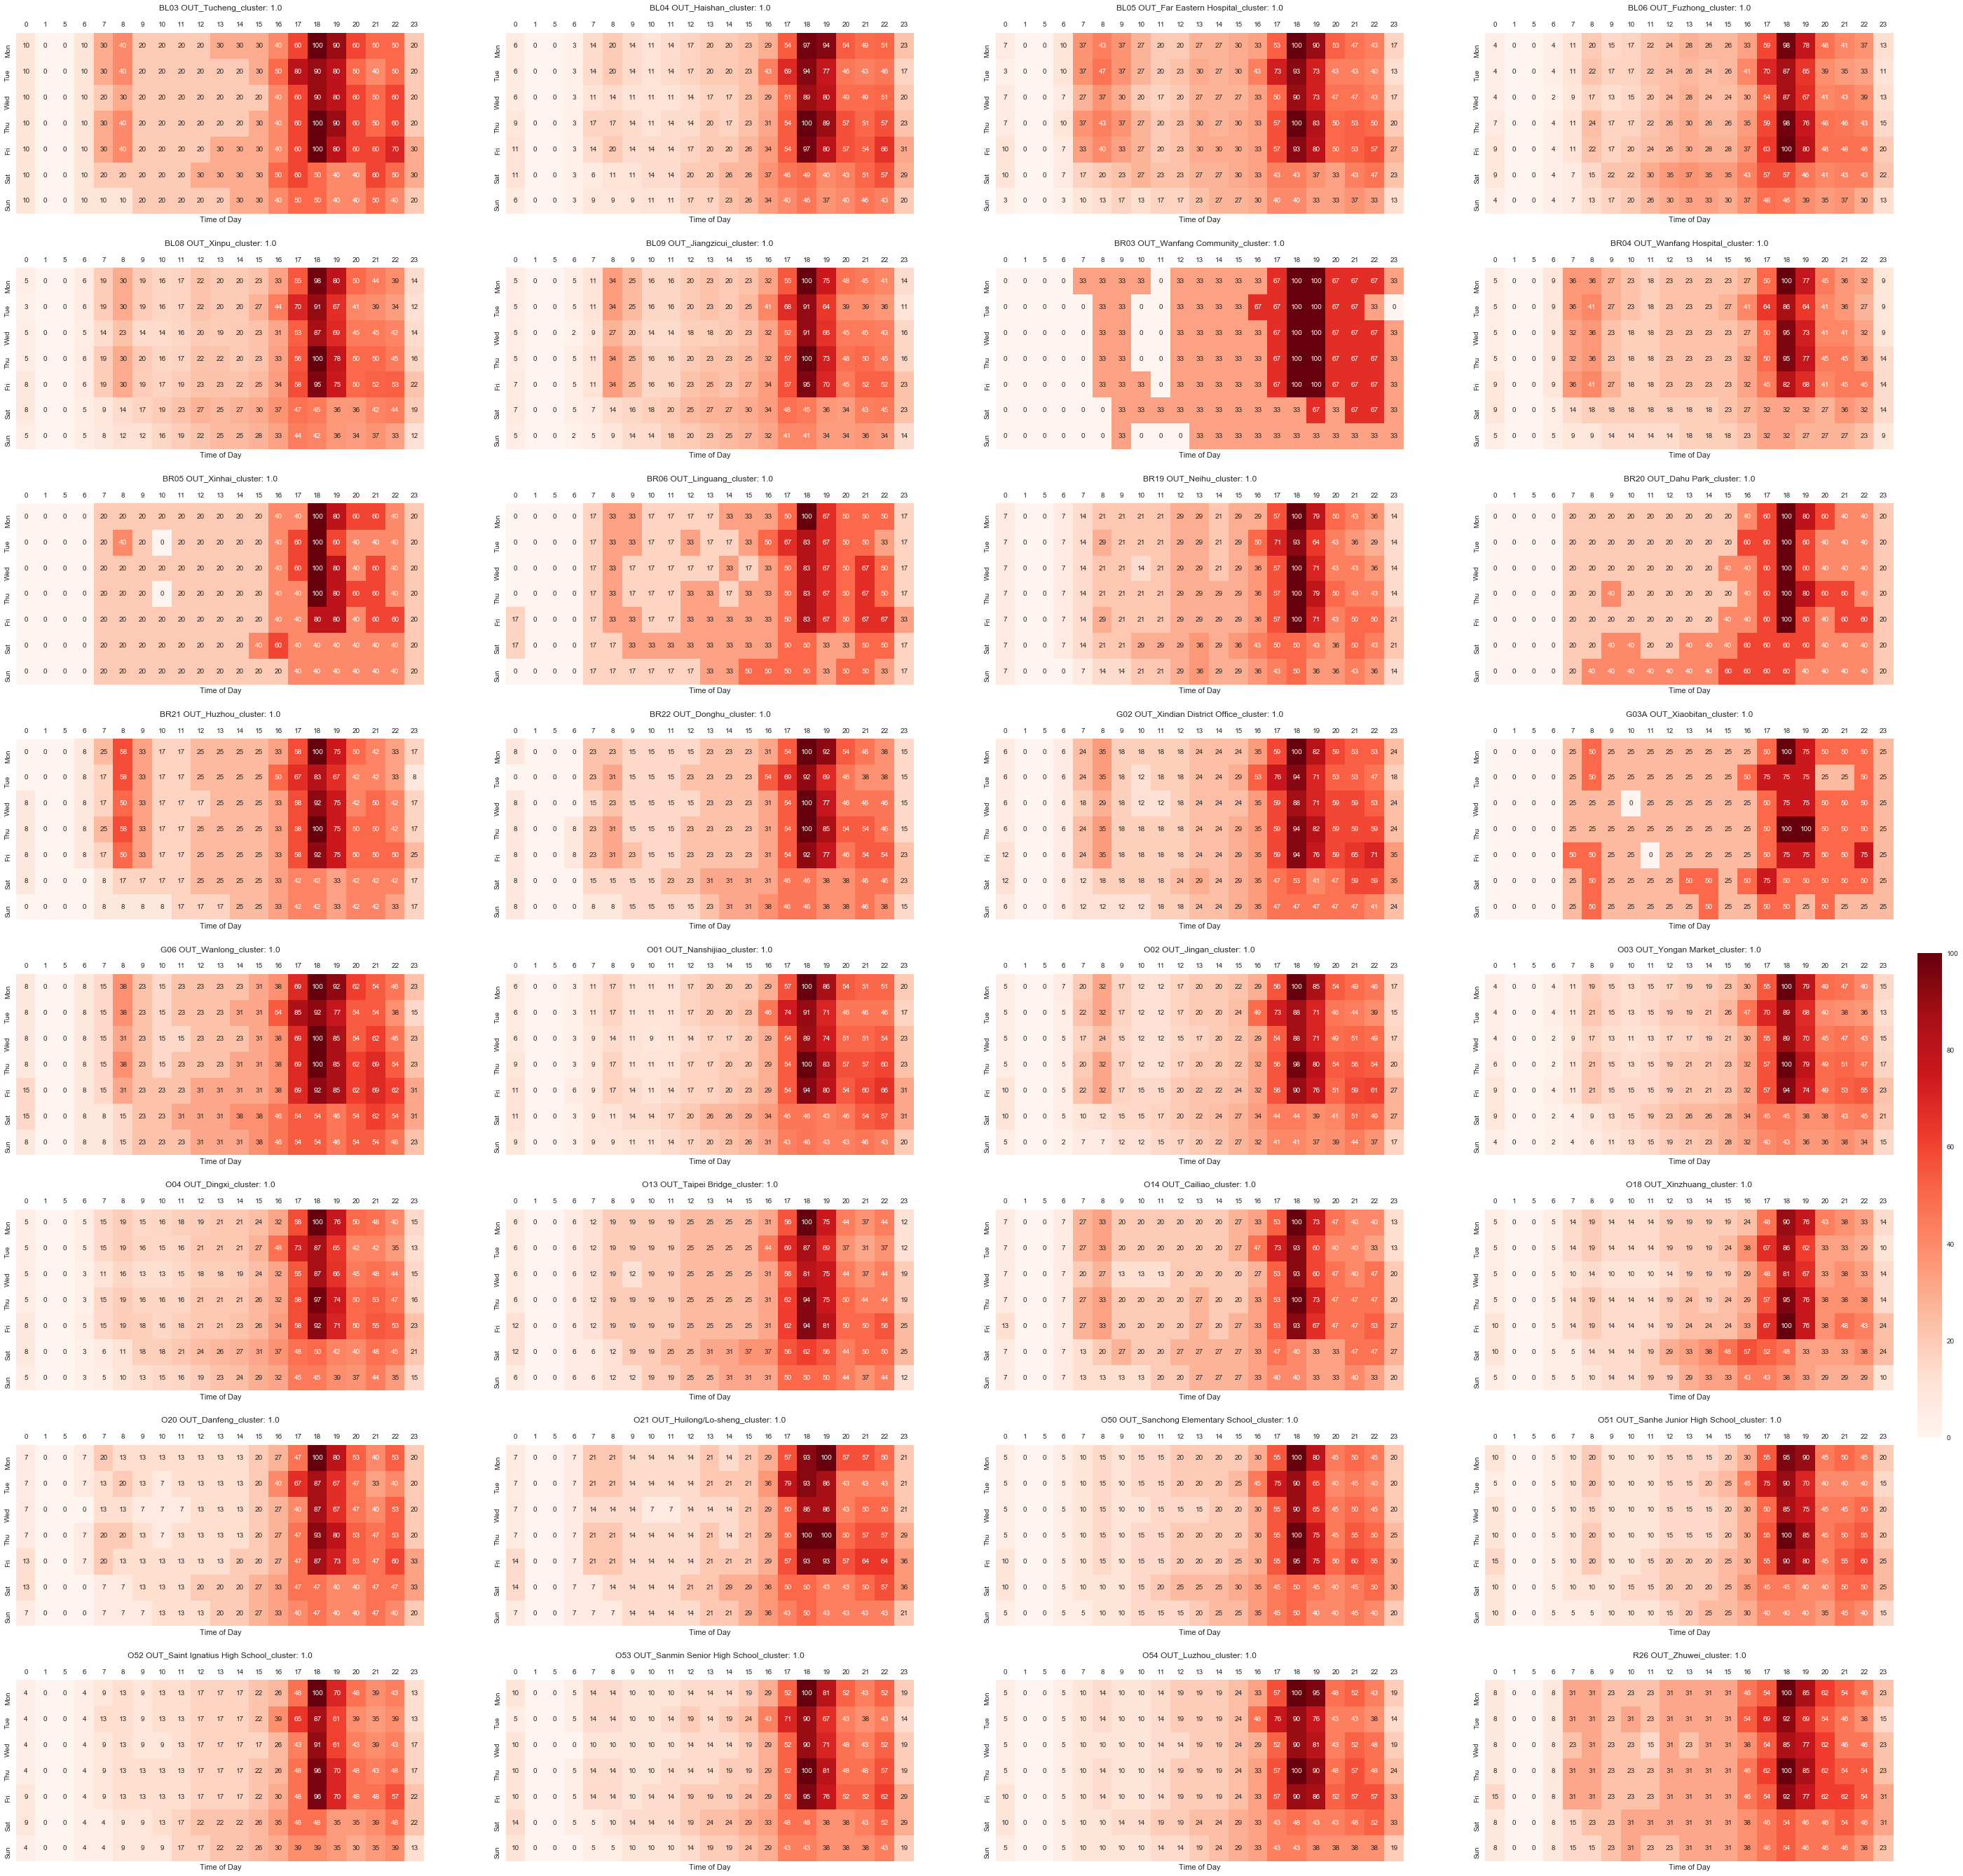

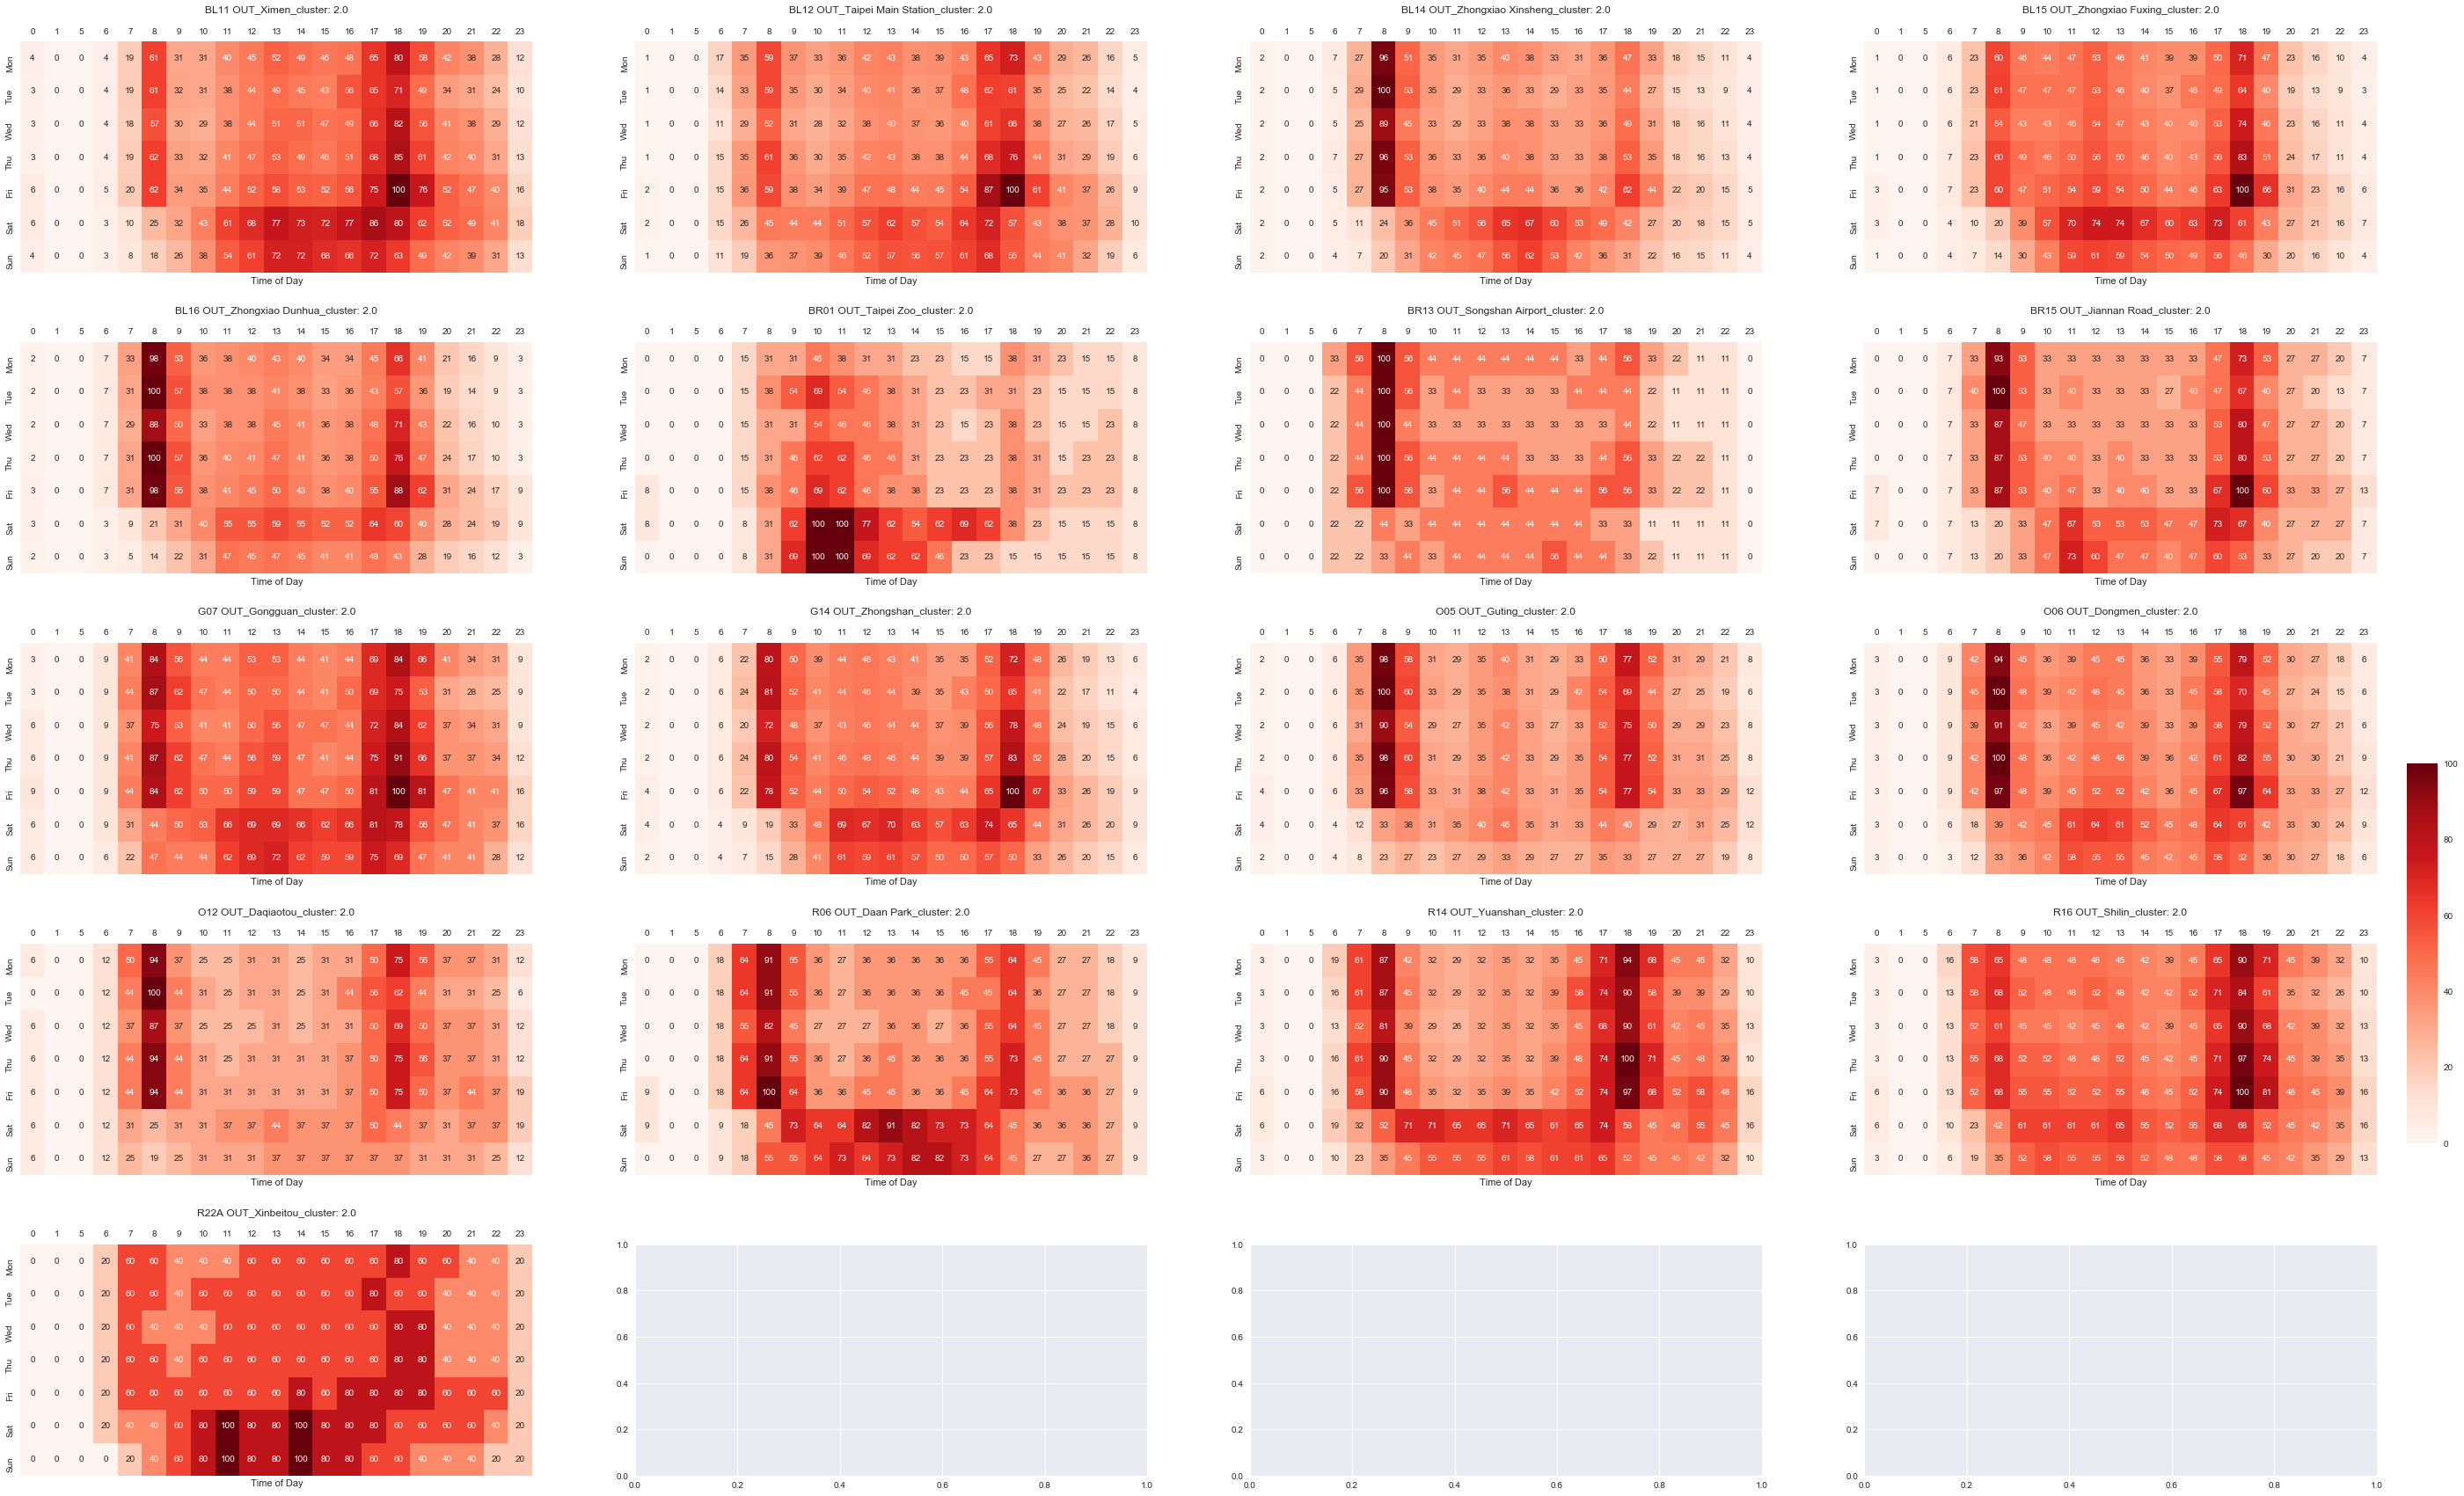

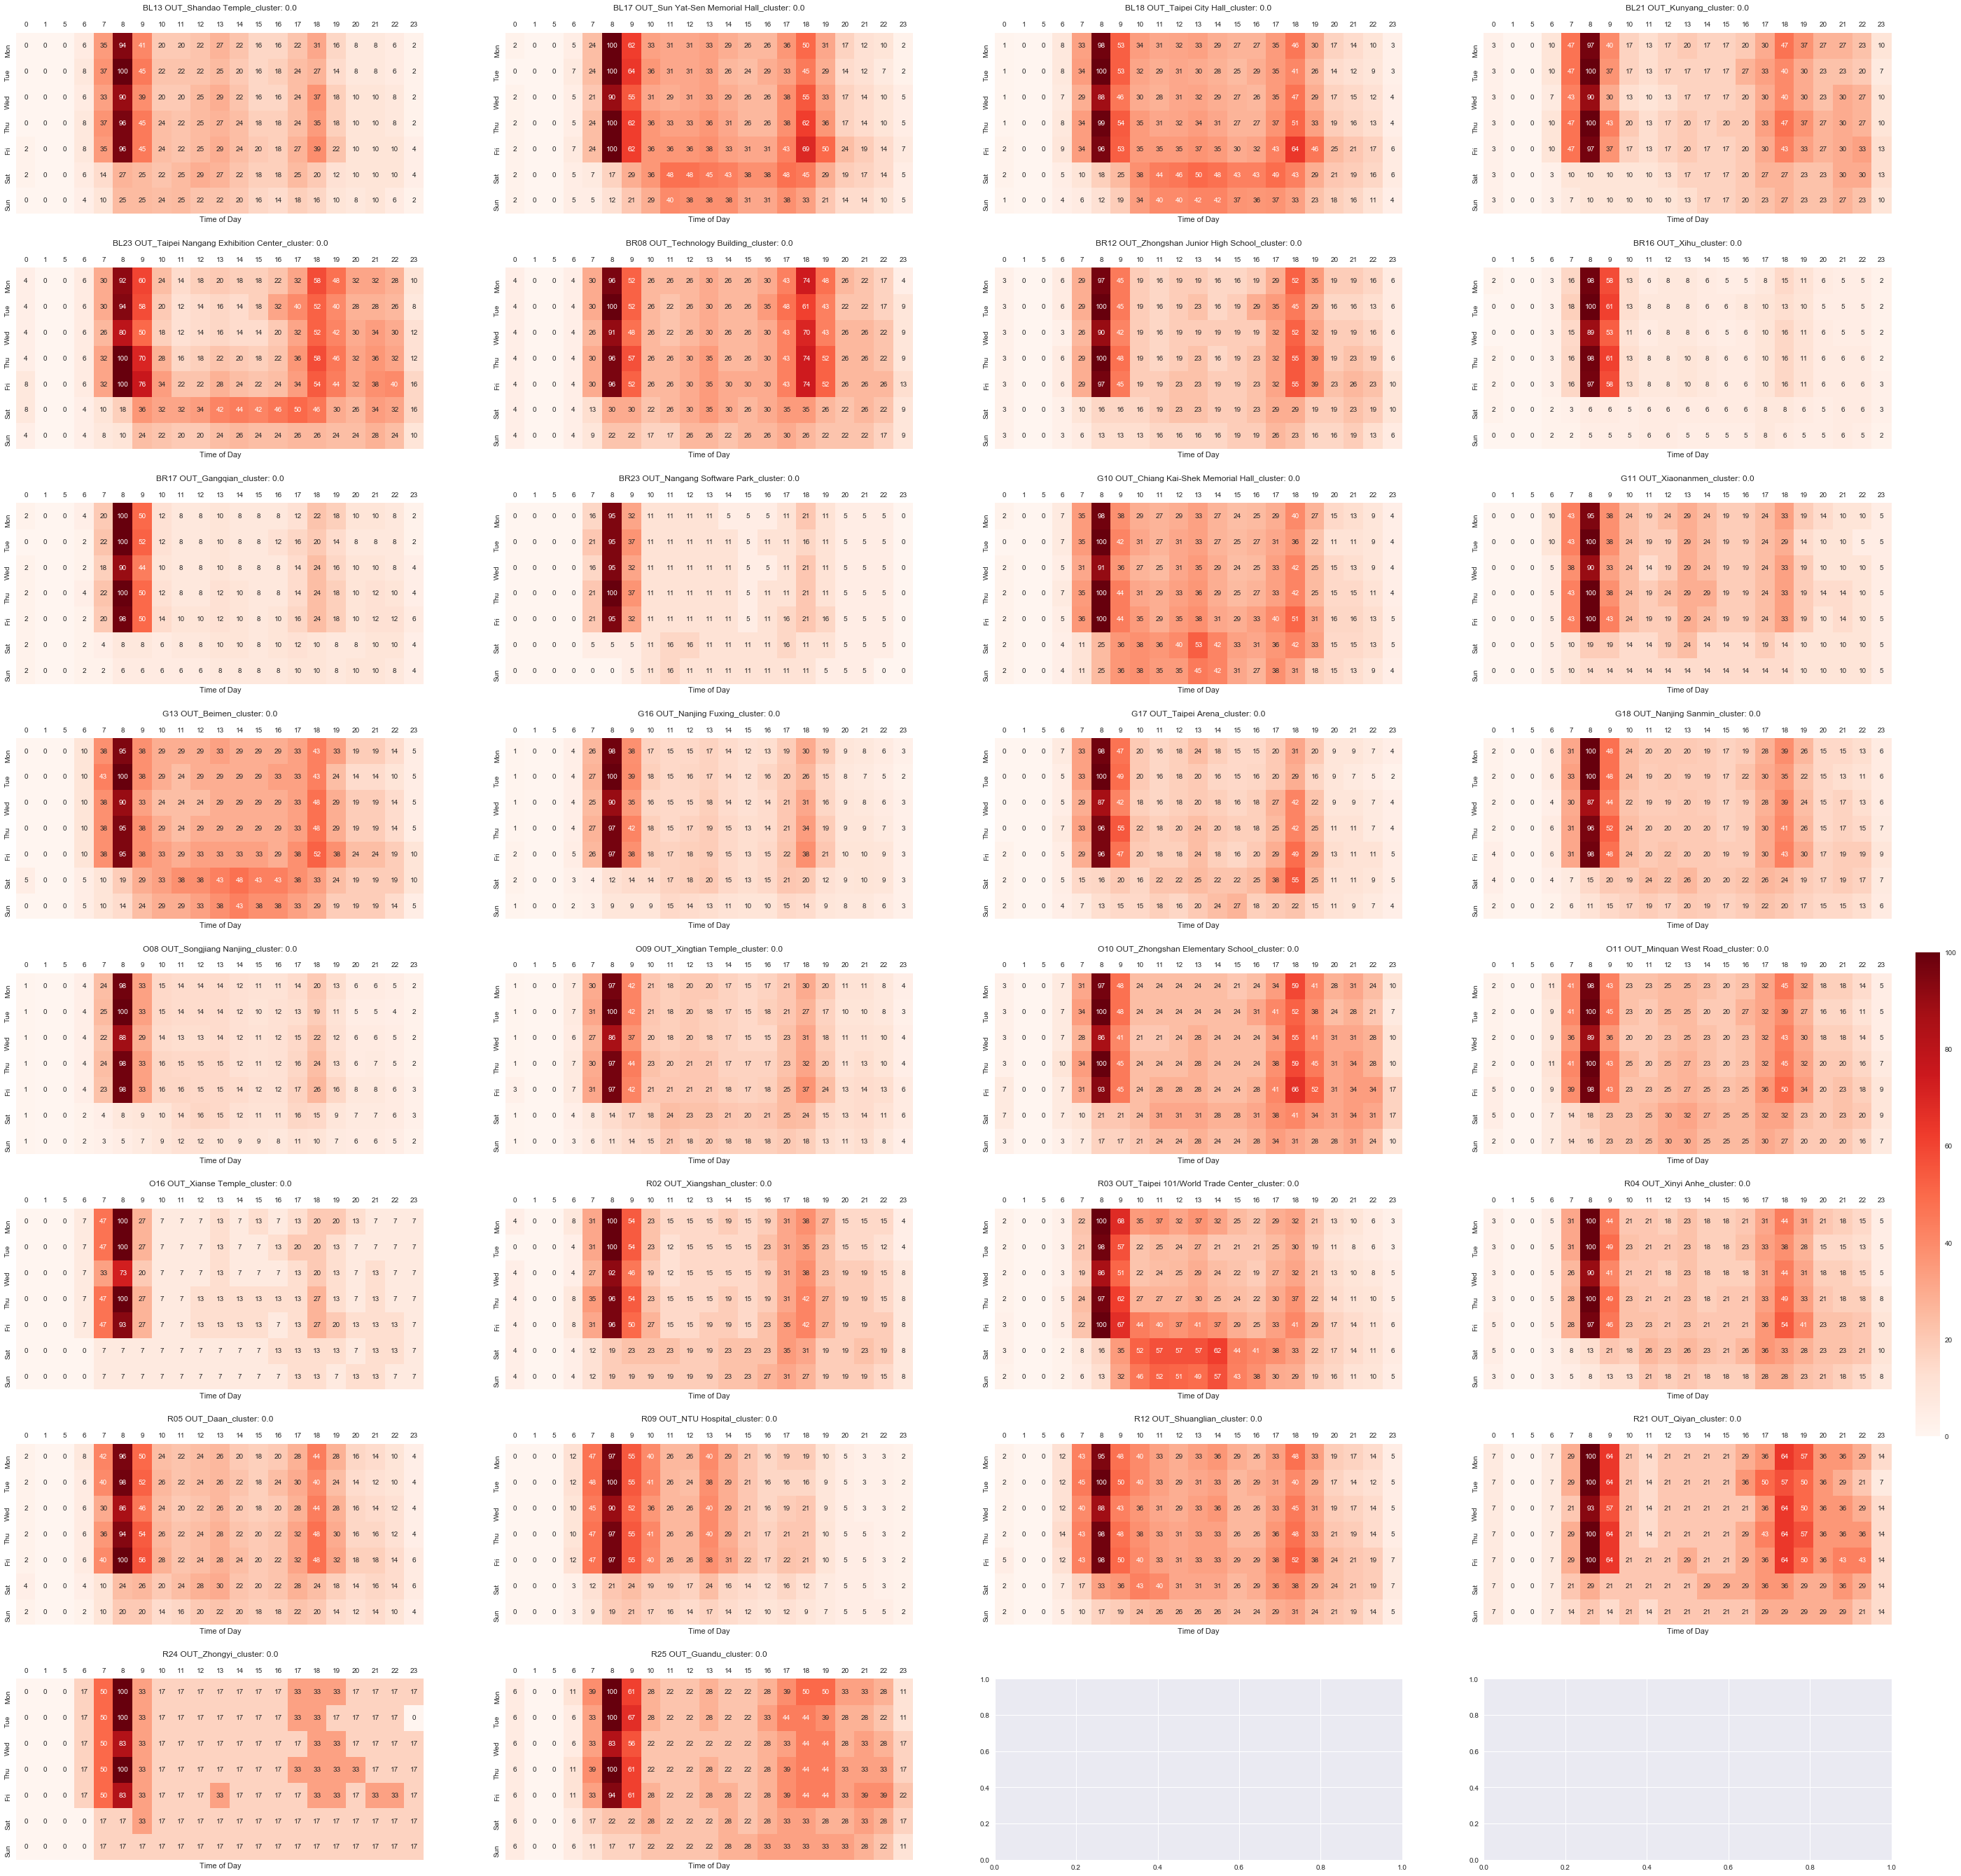

In [14]:
folder_name = 'notebook_illustration'
k_pack = K_means_package(folder_name,'forKmeans',4,4)

<a id='4'></a>
### [Part 4 Combine Entrance and Exit Result Using K_means_package](#0)


In [15]:

def station_name_df(df,name_dict):
    df['name'] = '--'
    for k,v in name_dict.items():
        df['name'][df.index == k] = name_dict[k]
        
def cluster_df(in_df,out_df,saving):
    code_name_dict = station_eng_name()
    #1 get cluster from kmeans function, clean and combine
    in_cluster = in_df['cluster'].copy()
    #rename index ex. from "BL11 OUT" to "BL11"
    in_cluster = in_cluster.rename(lambda x:x.split()[0])
    #rename series name
    in_cluster = in_cluster.rename('in_cluster')
    
    out_cluster = out_df['cluster'].copy()
    out_cluster = out_cluster.rename(lambda x:x.split()[0])
    out_cluster = out_cluster.rename('out_cluster')
    df_cluster = pd.concat([in_cluster, out_cluster], axis=1)

    #2 map the station name using station code
    station_name_df(df_cluster,code_name_dict)

    #3 create DataFrame
    df_cluster['in_cluster'] = df_cluster['in_cluster'].apply(str)
    df_cluster['out_cluster'] = df_cluster['out_cluster'].apply(str)
    df_cluster['in_out_cluster'] = df_cluster['in_cluster'] + '_' + df_cluster['out_cluster']
    df_cluster.to_csv('{}/df_cluster.csv'.format(saving), encoding='utf-8')

    print('Done')
    return df_cluster


In [17]:
df_final = cluster_df(k_pack[0],k_pack[1],folder_name)

/Users/unhumanWu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Done


In [18]:
#The combination of entrance and exit cluster groups
df_final['in_out_cluster'].value_counts()

0_1    32
2_0    21
3_3    14
1_2    14
0_3    13
3_0     5
1_0     4
3_2     3
1_3     2
Name: in_out_cluster, dtype: int64